**EXERCÍCIO 3**: modelo de previsão de falha.

Objetivo: desenvolver um modelo de predição de dispositivos, a partir dos dados de sensores.

# 0.0 IMPORTAÇÕES E DEFINIÇÕES

## 0.1 Importação de Bibliotecas

In [92]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import lines

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization, UtilityFunction

import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.metrics import Precision, Recall, AUC

import logging
logging.getLogger().setLevel(logging.INFO)

import warnings
warnings.filterwarnings('ignore')

## 0.2 Definições Auxiliares

In [93]:
# caminho completo de localização do arquivo .csv
FILE_PATH = '../data/full_devices.csv'

## 0.3 Carregamento dos Dados

In [94]:
# leitura do arquivo .csv
dataframe = pd.read_csv(
    FILE_PATH,
    encoding='ISO-8859-1'
)
dataframe.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


# 1.0 DESCRIÇÃO DOS DADOS

Descrição dos parâmetros:

- `date`: data de aferição dos parâmetros
- `device`: código de identificação do dispositivo
- `failure`: tag de classificação de falha
- `attribute1`: atributo #1
- `attribute2`: atributo #2
- `attribute3`: atributo #3
- `attribute4`: atributo #4
- `attribute5`: atributo #5
- `attribute6`: atributo #6
- `attribute7`: atributo #7
- `attribute8`: atributo #8
- `attribute9`: atributo #9

## 1.1 Dimensão dos Dados

In [95]:
raw_rows, raw_columns = dataframe.shape

print('Número inicial de linhas: {}'.format(raw_rows))
print('Número inicial de colunas: {}'.format(raw_columns))

Número inicial de linhas: 124494
Número inicial de colunas: 12


## 1.2 Tipos de Dados e Valores Faltantes

In [96]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


Não há colunas com **valores faltantes**.

É necessário o **ajuste do tipo de dados** da coluna:
- `date`: object &rarr; datetime

Apesar das demais colunas estarem com os tipos de dados corretos, por facilidade de generalização as colunas de atributos serão convertidas para `float64`

## 1.3 Limpeza e Adequação dos Dados

### 1.3.1 Registros duplicados

In [97]:
# verificação de registros duplicados
dataframe[dataframe.duplicated()]

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
101335,2015-07-10,S1F0R4Q8,0,192721392,0,0,0,8,213700,0,0,0


In [98]:
duplicates = dataframe[dataframe.duplicated()].shape[0]
print('Quantidade de registros duplicados: {} ({:.3%} da base total)'.format(duplicates, duplicates/raw_rows))

Quantidade de registros duplicados: 1 (0.001% da base total)


In [99]:
# remoção dos registros duplicados
dataframe.drop_duplicates(
    keep='first',
    inplace=True
)

print('Dimensão do dataframe atual: {}'.format(dataframe.shape))

Dimensão do dataframe atual: (124493, 12)


In [100]:
dataframe.columns

Index(['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8',
       'attribute9'],
      dtype='object')

### 1.3.2 Correção dos tipos de dados

In [101]:
# ajuste do tipo de dado dos parâmetros
dataframe = dataframe.astype(
    {
       'date': 'datetime64[ms]', 
       'attribute1': 'float64',
       'attribute2': 'float64',
       'attribute3': 'float64',
       'attribute4': 'float64',
       'attribute5': 'float64',
       'attribute6': 'float64',
       'attribute7': 'float64',
       'attribute8': 'float64',
       'attribute9': 'float64' 
    }
)

In [102]:
# verificando os tipos de dados após o ajuste
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124493 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        124493 non-null  datetime64[ms]
 1   device      124493 non-null  object        
 2   failure     124493 non-null  int64         
 3   attribute1  124493 non-null  float64       
 4   attribute2  124493 non-null  float64       
 5   attribute3  124493 non-null  float64       
 6   attribute4  124493 non-null  float64       
 7   attribute5  124493 non-null  float64       
 8   attribute6  124493 non-null  float64       
 9   attribute7  124493 non-null  float64       
 10  attribute8  124493 non-null  float64       
 11  attribute9  124493 non-null  float64       
dtypes: datetime64[ms](1), float64(9), int64(1), object(1)
memory usage: 12.3+ MB


## 1.4 Descrição Estatística

In [103]:
# separação dos parâmetros numéricos e categóricos (e data)
num_att = dataframe.select_dtypes(include=['int64', 'float64'])
cat_att = dataframe.select_dtypes(exclude=['int64', 'float64'])

### 1.4.1 Atributos numéricos

In [104]:
# estimadores de localização
mean_ = pd.DataFrame(num_att.apply(np.mean)).T
median_ = pd.DataFrame(num_att.apply(np.median)).T
min_ = pd.DataFrame(num_att.apply(np.min)).T
max_ = pd.DataFrame(num_att.apply(np.max)).T

# estimadores de variabilidade
std_ = pd.DataFrame(num_att.apply(np.std)).T
range_ = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T

# skewness e kurtosis
skew_ = pd.DataFrame(num_att.apply(lambda x: x.skew())).T
kurt_ = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

# concatenação dos estimadores
num_stats = pd.concat([min_, max_, range_, mean_, median_, std_, skew_, kurt_]).T.reset_index(drop=False)
num_stats.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mean', 'Median', 'Std','Skewness', 'Kurtosis']
num_stats

,Attributes,Min,Max,Range,Mean,Median,Std,Skewness,Kurtosis
0,failure,0.0,1.0,1.0,8.514535e-04,0.0,2.916725e-02,34.227056,1169.510135
1,attribute1,0.0,244140480.0,244140480.0,1.223875e+08,122797128.0,7.045905e+07,-0.011127,-1.199300
2,attribute2,0.0,64968.0,64968.0,1.594860e+02,0.0,2.179658e+03,23.857827,626.815514
3,attribute3,0.0,24929.0,24929.0,9.940535e+00,0.0,1.857473e+02,82.711947,10473.504485
4,attribute4,0.0,1666.0,1666.0,1.741134e+00,0.0,2.290851e+01,41.502446,2467.943121
5,attribute5,1.0,98.0,97.0,1.422272e+01,10.0,1.594302e+01,3.483663,12.152006
6,attribute6,8.0,689161.0,689153.0,2.601730e+05,249800.0,9.915099e+04,-0.375295,1.907760
7,attribute7,0.0,832.0,832.0,2.925305e-01,0.0,7.436924e+00,73.476162,6876.217830
8,attribute8,0.0,832.0,832.0,2.925305e-01,0.0,7.436924e+00,73.476162,6876.217830
9,attribute9,0.0,18701.0,18701.0,1.245162e+01,0.0,1.914256e+02,49.899079,4050.158157


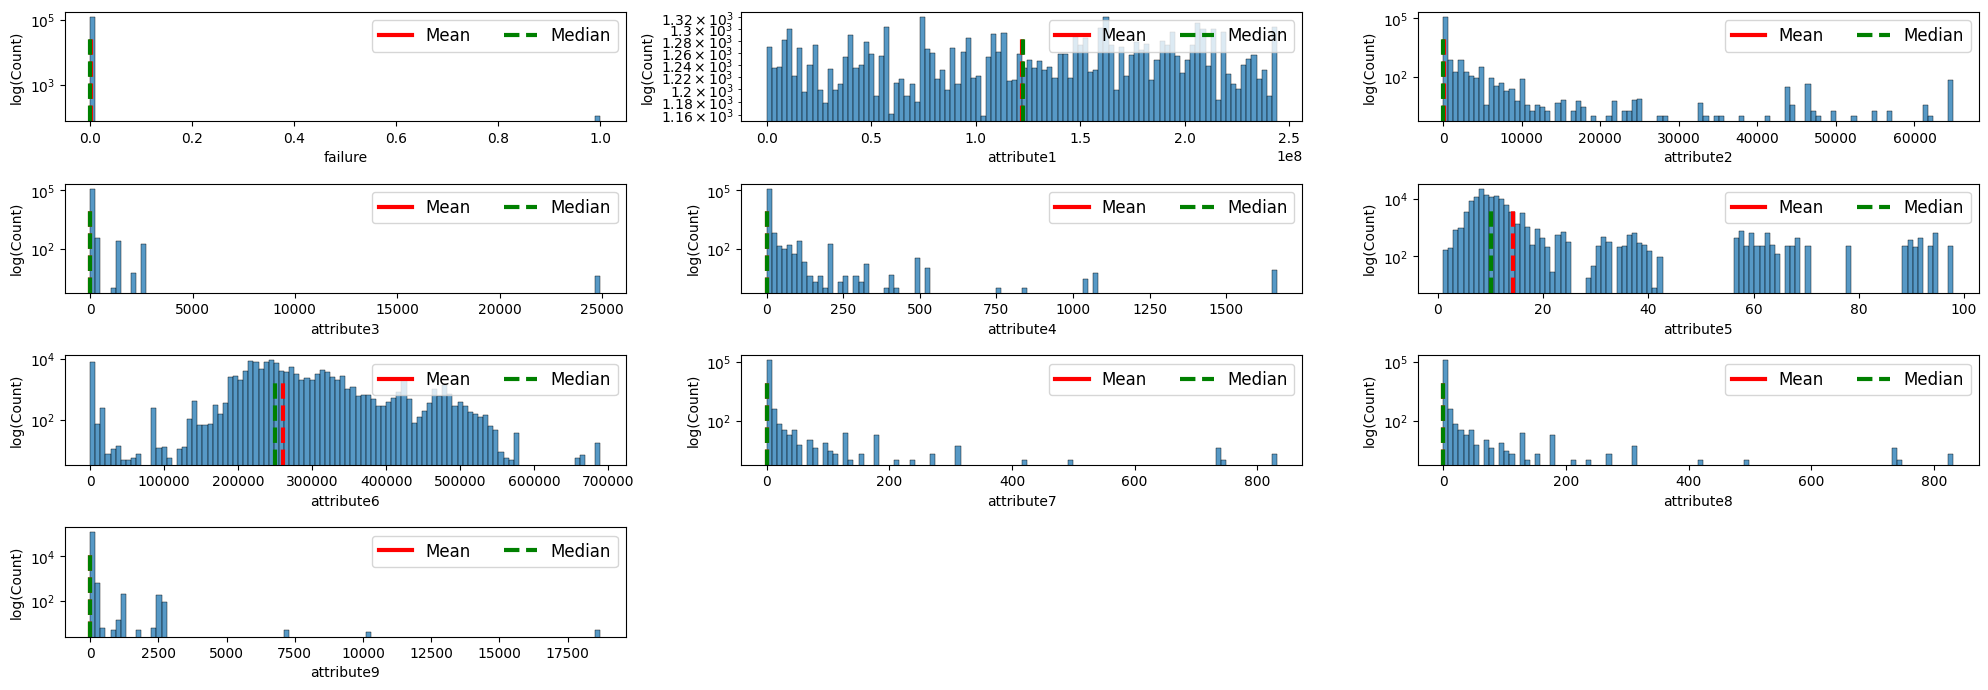

In [105]:
fig = plt.figure(figsize=(20, 7))
num_cols = num_att.columns

for i in range(10):
    plt.subplot(4, 3, i+1)
    sns.histplot(
        data=dataframe,
        x=num_cols[i],
        bins=100
    )

    plt.yscale('log')
    plt.ylabel('log(Count)')

    plt.axvline(
        x=dataframe[num_cols[i]].mean(),
        color='red',
        ymax=0.8,
        lw=3,
        linestyle='--'
    )
    plt.axvline(
        x=dataframe[num_cols[i]].median(),
        color='green',
        ymax=0.8,
        lw=3,
        linestyle='--'
    )

    custom_legends = [
        lines.Line2D([0], [0], color='red', linestyle='-', lw=3),
        lines.Line2D([0], [0], color='green', linestyle='--', lw=3),
    ]
    plt.legend(
        custom_legends,
        ['Mean', 'Median'],
        loc='upper right',
        fontsize=12,
        ncols=2
    )

plt.tight_layout()
plt.show()

### 1.4.2 Categorical attributes

In [106]:
# verificação do número de valores únicos e share de contribuição de cada valor nos parâmetros categóricos
for col in cat_att.columns:
    print('Number of distinct {} values: {}'.format(col, len(dataframe[col].unique())))
    print(dataframe[col].value_counts())
    print('-------------------------------------------------------------------------- \n')

Number of distinct date values: 304
date
2015-01-01    1163
2015-01-02    1163
2015-01-03    1163
2015-01-04    1162
2015-01-05    1161
              ... 
2015-10-27      31
2015-10-29      31
2015-10-30      31
2015-10-31      31
2015-11-02      31
Name: count, Length: 304, dtype: int64
-------------------------------------------------------------------------- 

Number of distinct device values: 1169
device
Z1F0QLC1    304
S1F0KYCR    304
S1F0E9EP    304
S1F0EGMT    304
S1F0FGBQ    304
           ... 
W1F1CHZK      5
W1F1CJKT      5
S1F04KSC      4
W1F0WJFT      3
W1F1DA5ÿ      1
Name: count, Length: 1169, dtype: int64
-------------------------------------------------------------------------- 



## 1.5 Análise das Variáveis Preditivas

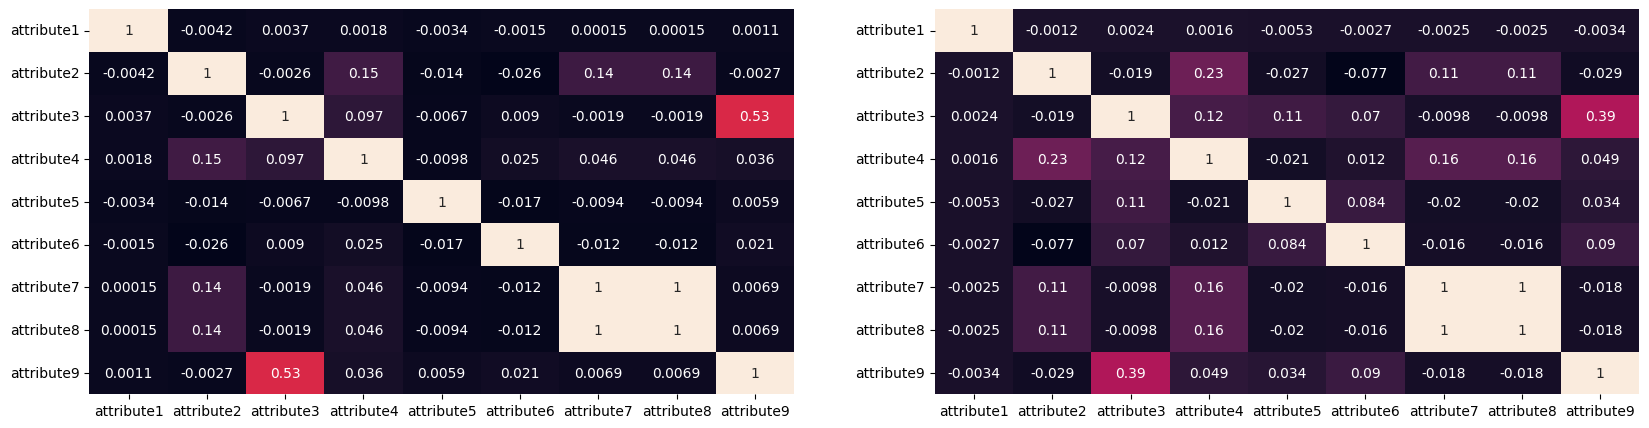

In [107]:
pred_columns = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']
fig = plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.heatmap(
    dataframe[pred_columns].corr('pearson'),
    cbar=False,
    annot=True
)

plt.subplot(1, 2, 2)
sns.heatmap(
    dataframe[pred_columns].corr('spearman'),
    cbar=False,
    annot=True
)

plt.show()

In [108]:
dataframe[dataframe['attribute7']!=dataframe['attribute8']].shape

(0, 12)

**Observações**:
- Os parâmetros `attribute7` e `attribute8` possuem correlação perfeita. Para a continuidade da solução apenas um dos parâmetros serão mantidos.

In [109]:
dataframe.drop(
    columns=['attribute8'],
    inplace=True
)

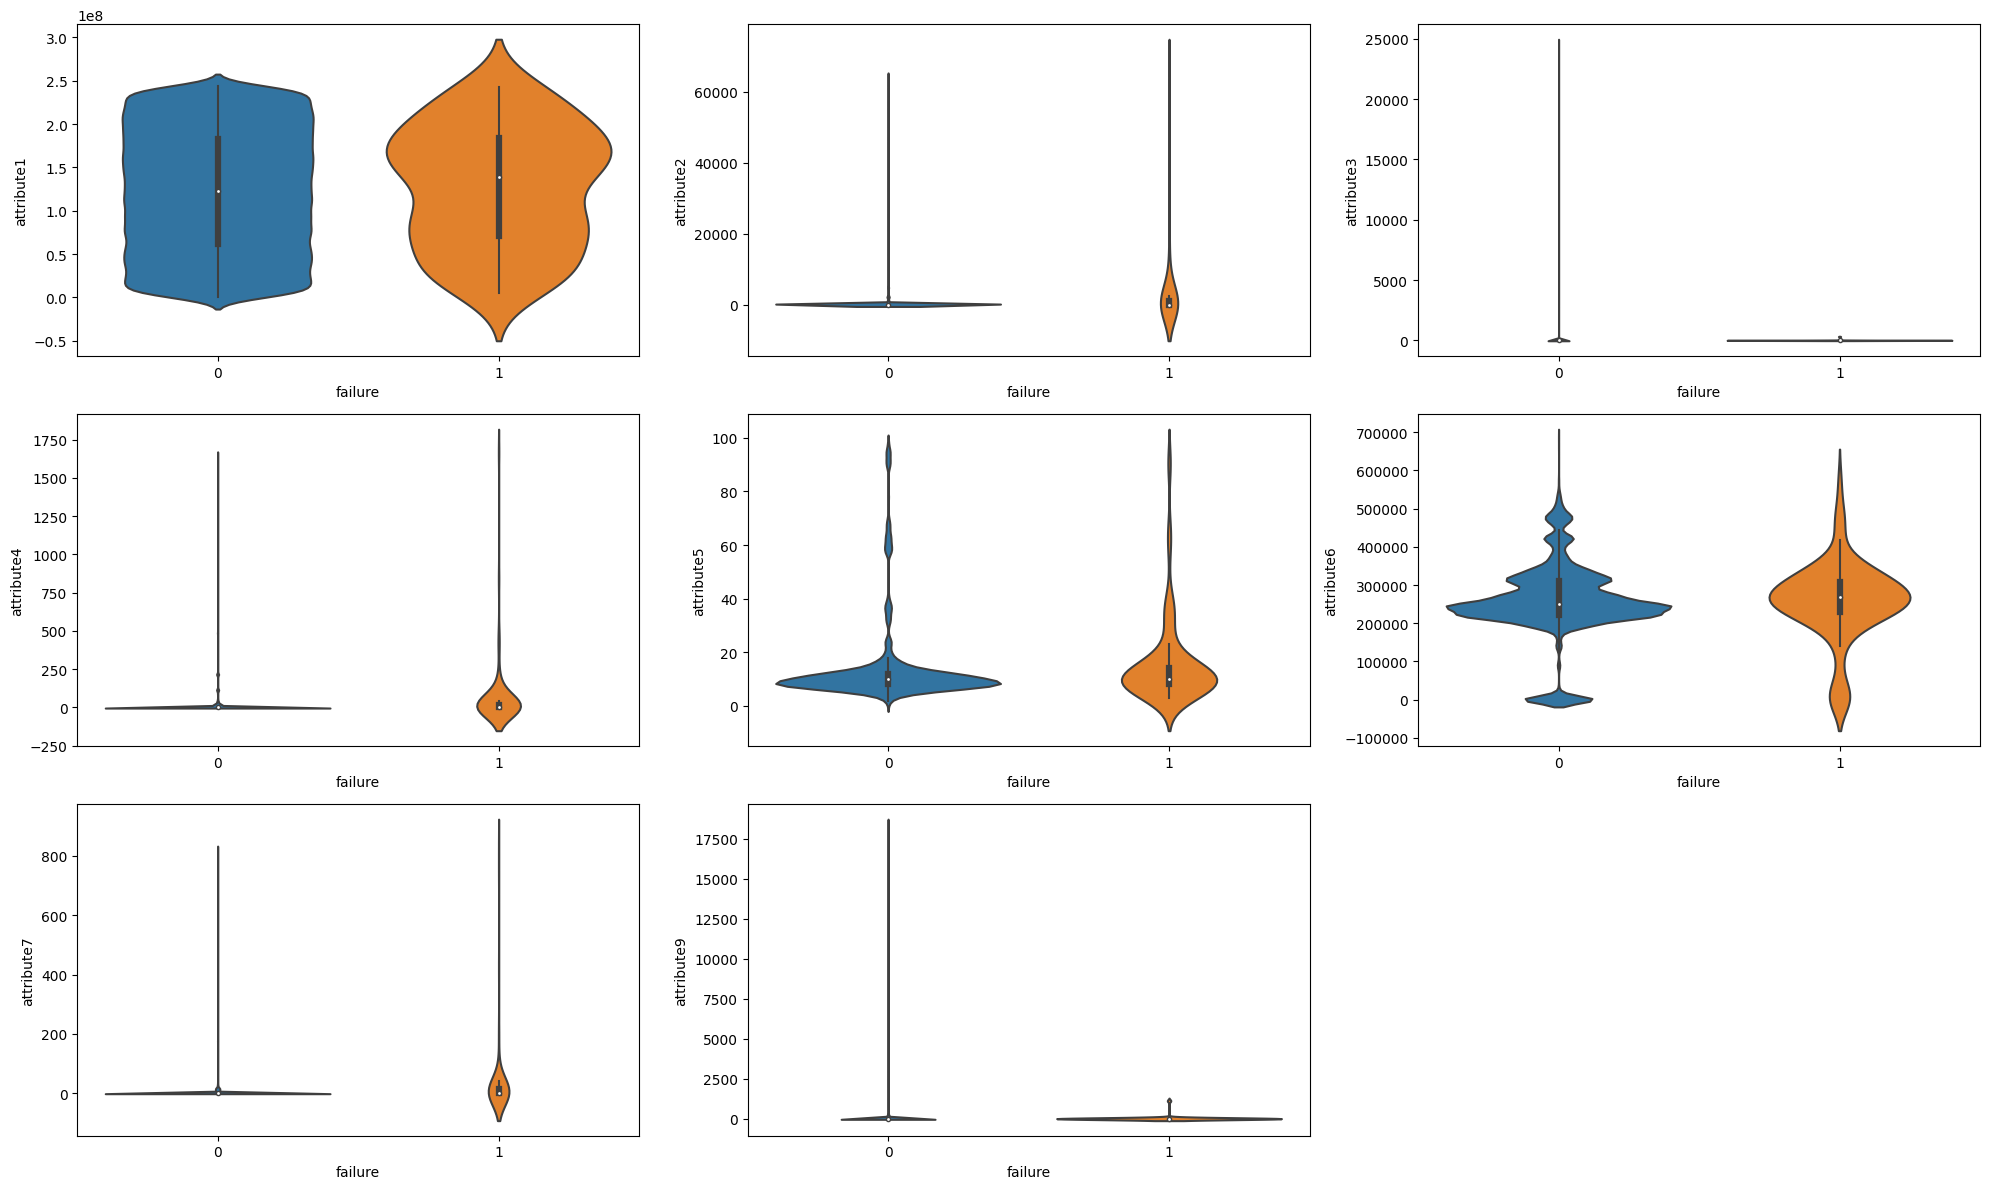

In [110]:
pred_columns = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']
fig = plt.figure(figsize=(20, 12))

for i in range(len(pred_columns)):
    plt.subplot(3, 3, i+1)
    sns.violinplot(
        data=dataframe,
        x='failure',
        y=pred_columns[i],
    )

plt.tight_layout()
plt.show()

In [111]:
pred_columns = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']
for col in pred_columns:
    print('Parâmetro {}'.format(col))
    print('- quantidade de valores zero: {} ({:.2%} da base total)'.format(dataframe[dataframe[col]==0].shape[0], dataframe[dataframe[col]==0].shape[0]/dataframe.shape[0]))
    print('- quantidade de valores zero em dispositivos com falha: {} ({:.2%} da base com falha)'.format(dataframe[(dataframe['failure']==1) & (dataframe[col]==0)].shape[0], dataframe[(dataframe['failure']==1) & (dataframe[col]==0)].shape[0]/dataframe[dataframe['failure']==1].shape[0]))
    print('- quantidade de valores zero em dispositivos sem falha: {} ({:.2%} da base com falha)\n'.format(dataframe[(dataframe['failure']==0) & (dataframe[col]==0)].shape[0], dataframe[(dataframe['failure']==1) & (dataframe[col]==0)].shape[0]/dataframe[dataframe['failure']==0].shape[0]))

Parâmetro attribute1
- quantidade de valores zero: 11 (0.01% da base total)
- quantidade de valores zero em dispositivos com falha: 0 (0.00% da base com falha)
- quantidade de valores zero em dispositivos sem falha: 11 (0.00% da base com falha)

Parâmetro attribute2
- quantidade de valores zero: 118109 (94.87% da base total)
- quantidade de valores zero em dispositivos com falha: 58 (54.72% da base com falha)
- quantidade de valores zero em dispositivos sem falha: 118051 (0.05% da base com falha)

Parâmetro attribute3
- quantidade de valores zero: 115358 (92.66% da base total)
- quantidade de valores zero em dispositivos com falha: 95 (89.62% da base com falha)
- quantidade de valores zero em dispositivos sem falha: 115263 (0.08% da base com falha)

Parâmetro attribute4
- quantidade de valores zero: 115155 (92.50% da base total)
- quantidade de valores zero em dispositivos com falha: 44 (41.51% da base com falha)
- quantidade de valores zero em dispositivos sem falha: 115111 (0.04% da 

## 1.6 Análise da Variável Alvo

In [112]:
failure = dataframe[dataframe['failure']==1].shape[0]
not_failure = dataframe[dataframe['failure']==0].shape[0]

print('Quantidade de registros com falha: {} ({:.2%} da base total)'.format(failure, failure/dataframe.shape[0]))
print('Quantidade de registros sem falha: {} ({:.2%} da base total)'.format(not_failure, not_failure/dataframe.shape[0]))

Quantidade de registros com falha: 106 (0.09% da base total)
Quantidade de registros sem falha: 124387 (99.91% da base total)


In [113]:
fail_devices = len(dataframe[dataframe['failure']==1]['device'].unique())
not_fail_devices = len(dataframe['device'].unique()) - fail_devices

print('Quantidade de dispositivos com falha: {} ({:.2%} da base total)'.format(fail_devices, fail_devices/len(dataframe['device'].unique())))
print('Quantidade de dispositivos sem falha: {} ({:.2%} da base total)'.format(not_fail_devices, not_fail_devices/len(dataframe['device'].unique())))

Quantidade de dispositivos com falha: 106 (9.07% da base total)
Quantidade de dispositivos sem falha: 1063 (90.93% da base total)


In [114]:
# verificando se existe dispositivo sem falha e com mais de uma falha
dataframe[['device', 'failure']].groupby(['device']).sum().reset_index(drop=False)['failure'].unique()

array([0, 1])

In [115]:
# verificando se nos dispositivos que apresentaram falha, o fenômeno ocorre sempre na última leitura
not_in_last_record = []
for id in dataframe[dataframe['failure']==1]['device'].unique():
    if dataframe[dataframe['device']==id]['date'].max() != dataframe[(dataframe['device']==id) & (dataframe['failure']==1)]['date'].values[0]:
        not_in_last_record.append(id)
    else:
        continue

not_in_last_record

['S1F136J0', 'W1F0KCP2', 'W1F0M35B', 'S1F0GPFZ', 'W1F11ZG9']

**Observações**:
- Existem registros que não apresentaram falha em nenhum momento.
- Os registros que apresentaram falha o fizeram apenas uma vez.
- Existem dispositivos com novos registros após a falha.

# 2.0 ENGENHARIA DE PARÂMETROS

## 2.1 `about_to_fail`

Como o objetivo é prever a falha antes dela acontecer, será criado o parâmetro `about_to_fail` que indicará que o dispositivo irá chegar a falha dentro de uma janela temporal definida. Para essa solução iremos trabalhar com a janela temporal de um registro, ou seja, o valor do parâmetro será positivo um registro antes daquele que acusar a falha.

In [116]:
# criação do parâmetro `rul` referente a quantos dias até seu último registro ou até a falha do dispositivo
fail_devices = dataframe[dataframe['failure']==1]['device'].unique()
for dev in dataframe['device'].unique():
    if dev in fail_devices:
        dataframe.loc[dataframe[dataframe['device']==dev].index, 'rul'] = (dataframe[(dataframe['device']==dev) & (dataframe['failure']==1)]['date'].values[0] - dataframe[dataframe['device']==dev]['date'])/np.timedelta64(1, 'D')
    else:
        dataframe.loc[dataframe[dataframe['device']==dev].index, 'rul'] = (dataframe[dataframe['device']==dev]['date'].max() - dataframe[dataframe['device']==dev]['date'])/np.timedelta64(1, 'D')

In [117]:
# definição da janela temporal de aviso sobre a falha do dispositivo
fail_window = 1

# criação do parâmetro `about_to_fail`
fail_devices = dataframe[dataframe['failure']==1]['device'].unique()
dataframe['about_to_fail'] = np.where(
    ((dataframe['device'].isin(fail_devices)) &
    (dataframe['failure']==0) &
    (dataframe['rul']<=fail_window)),
1, 0)

# a quantidade de positivos para `about_to_fail` deve ser igual a quantidade de `failure`
dataframe['failure'].sum(), dataframe['about_to_fail'].sum()

(106, 151)

In [118]:
# verificando a existência de dispositivos com positivo para `failure` e não para `about_to_fail`
check_values_df = dataframe[dataframe['rul']>=0][['device', 'failure', 'about_to_fail']].groupby(['device']).sum().reset_index(drop=False).sort_values(['failure'], ascending=False).iloc[:,:]
check_values_df[(check_values_df['failure']==1) & (check_values_df['about_to_fail']==0)]

,device,failure,about_to_fail
447,S1F11MB0,1,0
401,S1F10E6M,1,0


In [119]:
dataframe[dataframe['device'].isin(['S1F11MB0', 'S1F10E6M'])]

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,rul,about_to_fail
397,2015-01-01,S1F10E6M,0,210550904.0,1080.0,0.0,0.0,7.0,202433.0,0.0,0.0,28.0,0
443,2015-01-01,S1F11MB0,0,173113976.0,0.0,0.0,0.0,5.0,198441.0,0.0,0.0,28.0,0
1560,2015-01-02,S1F10E6M,0,112747544.0,1080.0,0.0,0.0,7.0,202433.0,0.0,0.0,27.0,0
1606,2015-01-02,S1F11MB0,0,120647592.0,0.0,0.0,0.0,5.0,198441.0,0.0,0.0,27.0,0
2723,2015-01-03,S1F10E6M,0,147840840.0,1080.0,0.0,0.0,7.0,202433.0,0.0,0.0,26.0,0
2769,2015-01-03,S1F11MB0,0,100757160.0,0.0,0.0,0.0,5.0,198441.0,0.0,0.0,26.0,0
3886,2015-01-04,S1F10E6M,0,9282448.0,1080.0,0.0,0.0,7.0,202433.0,0.0,0.0,25.0,0
3932,2015-01-04,S1F11MB0,0,192750960.0,0.0,0.0,0.0,5.0,198441.0,0.0,0.0,25.0,0
5047,2015-01-05,S1F10E6M,0,204287912.0,1080.0,0.0,0.0,7.0,202433.0,0.0,0.0,24.0,0
5093,2015-01-05,S1F11MB0,0,211589728.0,0.0,0.0,0.0,5.0,198441.0,0.0,0.0,24.0,0


Os dispositivos listados acima possuem uma janela temporal grande entre o registro de falha e o registro anteriormente realizado. Como não temos informação dos registros imediatamente anteriores à falha, iremos considerar esses dispositivos para criação do modelo.

In [120]:
# remoção de registros posteriores às falhas dos dispositivos
dataframe.drop(
    dataframe[dataframe['rul']<0].index,
    axis=0,
    inplace=True
)

# remoção dos dispositivos com intervalo de medições entre o registro de falha e os registros imediatamente anteriores
dataframe.drop(
    dataframe[dataframe['device'].isin(['S1F11MB0', 'S1F10E6M'])].index,
    axis=0,
    inplace=True
)

# conferência sobre a quantidade de positivos para `failure` e `about_to_fail`
dataframe['failure'].sum(), dataframe['about_to_fail'].sum()

(104, 104)

In [121]:
# remoção dos registros de falha (o objetivo será prever o registro anterior à falha)
dataframe.drop(
    dataframe[dataframe['failure']==1].index,
    axis=0,
    inplace=True
)

# remoção de colunas que não serão utilizadas no modelo
dataframe.drop(
    #columns=['failure', 'rul'],
    columns=['failure'],
    inplace=True
)

# 3.0 CRIAÇÃO DOS MÓDULOS E FUNÇÕES

Para esse exercício, foi decidido criar os fluxos principais de preparação, transformação, modelagem e predição dos dados utilizando módulos e funções.

Para facilitar a leitura e avaliação do trabalho, os módulos e funções foram agrupados nesta seção.

**PREPARAÇÃO DOS DADOS**

In [145]:
class DataTransformation:
    '''
    Classe destinada é métodos de transformação dos dados, como normalização e escalonamento.
    '''
    def __init__(self, dataframe: pd.DataFrame):
        self.dataframe = dataframe

    def normalize(self, norm_cols: list):
        '''
        Em cada coluna selecionada, soma o valor mínimo da coluna à todos seus registros, para evitar valores zero, e realiza a normalização da coluna aplicando log.
        Os valores normalizados são salvos em novas colunas, com padrão de nome 'norm_NOME_DA_COLUNA'

        Args:
          norm_cols: lista de colunas que serão normalizadas.

        Returns:
          self.
        '''
        for col in norm_cols:

            # adição do valor mínimo de cada coluna, removendo zeros, para remoção de valores nulos
            self.dataframe[f'norm_{col}'] = self.dataframe[col] + self.dataframe.drop(self.dataframe[self.dataframe[col]==0].index, axis=0)[col].min()

            # realização do processo de normalização a partir de aplicação de log
            self.dataframe[f'norm_{col}'] = np.log(self.dataframe[f'norm_{col}'])

        return self
    
    def __prepare_to_split(self, train_size: float=0.9, val_size: float=0.8888):
        '''
        Faz a separação inicial do dataframe no grão de dipositivos, estratificando pela proporção do atributo `about_to_fail`.

        Args:
          train_size: tamanho do dataframe de treino que será criado (pré-definido como 0.9).
          val_size: tamanho do dataframe de validação que será criado (pré-definido como 0.8888).

        Returns:
          X_id_opt: lista com códigos de identifição dos dispositivos que farão parte do dataframe de otimização.
          X_id_val: lista com códigos de identifição dos dispositivos que farão parte do dataframe de validação.
          X_id_test: lista com códigos de identifição dos dispositivos que farão parte do dataframe de treino.
        '''

        # criação de dataframe auxiliar com códigos dos dipositivos e atributo que indica falha (grão de dispositivo)
        dataframe_split = self.dataframe[['device', 'about_to_fail']].groupby(['device']).max().reset_index(drop=False)

        X_id_train, X_id_test, y_train, y_test = train_test_split(
            dataframe_split['device'],
            dataframe_split['about_to_fail'],
            train_size=train_size,
            stratify=dataframe_split['about_to_fail'],
            random_state=42
        )

        X_id_opt, X_id_val, y_opt, y_val = train_test_split(
            X_id_train,
            y_train,
            train_size=val_size,
            stratify=y_train,
            random_state=42
        )

        #logging.info('Dispositivos selecionados para separação.')
        #logging.info('Dispositivos em dataframe_opt: {} | Dispositivos em dataframe_opt: {} | Dispositivos em dataframe_opt: {}'.format(len(X_id_opt), len(X_id_val), len(X_id_test)))
        return X_id_opt, X_id_val, X_id_test
    
    def stratified_split(self, split_cols: list):
        '''
        Realiza a separação definitiva do dataframe em bases de otimização, validação e treino (grão de registros), realizando a estratificação pela proporção do atributo `about_to_fail`.

        Args:
          split_cols: lista de colunas que farão parte dos dataframes pós-separação.

        Returns:
          self.
        '''

        # definição das listas de dispositivos que farão parte das bases de otimização, validação e teste
        X_id_opt, X_id_val, X_id_test = self.__prepare_to_split()

        # a partir dos códigos de identificação dos dispositivos, serão criadas as bases com os atributos de predição selecionados
        self.dataframe_opt = self.dataframe[self.dataframe['device'].isin(X_id_opt.values)].sort_values(['device', 'date'], ascending=(True, True))[split_cols]
        self.dataframe_val = self.dataframe[self.dataframe['device'].isin(X_id_val.values)].sort_values(['device', 'date'], ascending=(True, True))[split_cols]
        self.dataframe_test = self.dataframe[self.dataframe['device'].isin(X_id_test.values)].sort_values(['device', 'date'], ascending=(True, True))[split_cols]

        #logging.info('Base de dados separada.')
        #logging.info('dataframe_opt.shape: {} | dataframe_val.shape: {} | dataframe_test.shape: {}'.format(self.dataframe_opt.shape, self.dataframe_val.shape, self.dataframe_test.shape))
        return self
    
    def scale_data(self, pred_cols: list):
        '''
        Realiza o escalonamento de atributos selecionados. Os valores escalonados são salvos na própria coluna, sobrescrevendo os valores antigos.

        Args:
          pred_cols: lista de colunas que serão escalonadas.

        Returns:
          dataframe_opt: base de dados de otimização, com valores escalonados.
          dataframe_val: base de dados de validação, com valores escalonados.
          dataframe_test: base de dados de teste, com valores escalonados.
        '''

        # realização do escalonamento
        scaler = MinMaxScaler()
        for col in pred_cols:
            self.dataframe_opt[col] = scaler.fit_transform(self.dataframe_opt[[col]])
            self.dataframe_val[col] = scaler.transform(self.dataframe_val[[col]])
            self.dataframe_test[col] = scaler.transform(self.dataframe_test[[col]])

        return self.dataframe_opt, self.dataframe_val, self.dataframe_test
    
class DataPreparation:
    '''
    Classe destinada é métodos de preparação dos dados, como parametrização e separação de variáveis preditoras e alvo.
    '''
    def __init__(self):
        pass

    def create_features(self, dataframe: pd.DataFrame, pred_cols: list, time_window: int):
        '''
        Realiza a parametrização dos dados, agrupando parâmetros dos dispositivos dentro da janela temporal definida.
        Os dispositivos que não possuem registros suficiente para parametrização são descartados.

        Args:
          dataframe: dataframe com registros de funcionamento dos dispositivos que serão parametrizados.
          pred_cols: lista de colunas que passarão pelo processo de parametrização.
          time_window: janela temporal que será utilizada para lookback na parametrização.

        Returns:
          self.
        '''

        self.dataframe = dataframe
        # iteração sobre as colunas selecionadas
        for col in pred_cols:
            
            # iteração na janela temporal definida
            for i in range(1, time_window):
                
                # definição do parâmetro `NOME_DA_COLUNA_lagJANELA_TEMPORAL` referente ao valor do parâmetro `NOME_DA_COLUNA` no intervalo D-JANELA_TEMPORAL
                dataframe[f'{col}_lag{i}'] = dataframe.groupby('device')[col].shift(i)

        # remoção de registros com valores null, referentes à dispositivos com quantidade de registros menores que a janela temporal definida
        dataframe.dropna(inplace=True)
        
        return self
    
    def get_target(self, target: str):
        '''
        Realiza a separação das variáveis preditoras e alvo em um dataframe.

        Args:
          target: nome da variável alvo.

        Returns:
          dataframe.drop(columns=[target]): dataframe contendo as variáveis preditoras.
          dataframe[target]: array contendo a variável alvo.
        '''
        return self.dataframe.drop(columns=[target]), self.dataframe[target]

In [146]:
class GetData:
    '''
    Classe destinada à abstração e simplificação do fluxo de preparo e transformação dos dados.
    '''
    def __init__(self, dataframe: pd.DataFrame):
        self.dataframe = dataframe
        self.transformer = DataTransformation(self.dataframe)
        self.preparer = DataPreparation()
        self.norm_cols = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']
        self.split_cols = ['date', 'device', 'norm_attribute1', 'norm_attribute2', 'norm_attribute3', 'norm_attribute4', 'norm_attribute5', 'norm_attribute6', 'norm_attribute7', 'norm_attribute9', 'about_to_fail']
        self.pred_cols = ['norm_attribute1', 'norm_attribute2', 'norm_attribute3', 'norm_attribute4', 'norm_attribute5', 'norm_attribute6', 'norm_attribute7', 'norm_attribute9']

    def parse(self, time_window: int):
        '''
        Realiza o fluxo complexo de preparo e transformação dos dados.

        Args:
          time_window: janela temporal definida.

        Returns:
          X_opt: dataframe contendo as variáveis preditoras da base de otimização.
          y_opt: array contendo a variável alvo da base de otimização.
          X_val: dataframe contendo as variáveis preditoras da base de validação.
          y_val: array contendo a variável alvo da base de validação.
          X_test: dataframe contendo as variáveis preditoras da base de teste.
          y_test: array contendo a variável alvo da base de teste.
        '''
        
        dataframe_opt, dataframe_val, dataframe_test = self.transformer.normalize(norm_cols=self.norm_cols).stratified_split(split_cols=self.split_cols).scale_data(pred_cols=self.pred_cols)

        X_opt, y_opt = self.preparer.create_features(dataframe_opt, pred_cols=self.pred_cols, time_window=time_window).get_target('about_to_fail')
        X_val, y_val = self.preparer.create_features(dataframe_val, pred_cols=self.pred_cols, time_window=time_window).get_target('about_to_fail')
        X_test, y_test = self.preparer.create_features(dataframe_test, pred_cols=self.pred_cols, time_window=time_window).get_target('about_to_fail')

        return X_opt, y_opt, X_val, y_val, X_test, y_test

**OTIMIZAÇÃO DE HIPERPARÂMETROS**

In [155]:
class LogRegOpt:
    '''
    Classe destinada aos processos e métodos de otimização do modelo de regressão logística.
    '''
    def __init__(self, X_opt: pd.DataFrame, y_opt: pd.Series, X_val: pd.DataFrame, y_val: pd.Series, pred_cols: list, class_weights: dict):
        self.X_opt = X_opt[pred_cols]
        self.y_opt = y_opt
        self.X_val = X_val[pred_cols]
        self.y_val = y_val
        self.class_weights = class_weights
        self.params_range = {
            'tol': (1e-4, 1e-2),
            'C': (0.5, 1.5),
            'max_iter': (300, 500)
        }
    
    def bayesian_optimizer(self):
        '''
        Realiza a otimização bayesiana dos hiperparâmetros do modelo de regressão logística.

        Args:

        Returns:
          bayes_list[0]['params']: lista dos hiperparâmetros que retornaram o valor otimizado da métrica de avaliação.
        '''

        # definição da função responsável pela criação e ajuste do modelo utilizando o conjunto de hiperparâmetros selecionados
        def black_box_function(
            tol,
            C,
            max_iter):

            model = LogisticRegression(
                tol=tol,
                C=C,
                max_iter=int(max_iter),
                class_weight=self.class_weights
            )

            model.fit(self.X_opt, self.y_opt)

            yhat = model.predict(self.X_val)
            f = f1_score(self.y_val, yhat)

            return f

        # método responsável pela escolha do caminho a ser explorado no espaço de hiperparâmetros
        optimizer = BayesianOptimization(
            f=black_box_function,
            pbounds=self.params_range,
            verbose=0,
            random_state=42)
        optimizer.maximize()

        # lista com conjunto de hiperparâmetros e métrica de avaliação obtidos em cada rodada de ajuste
        bayes_list = sorted(
            optimizer.res,
            key=lambda x: x['target'],
            reverse=True)
    
        return bayes_list[0]['params']
    
class LGBMOpt:
    '''
    Classe destinada aos processos e métodos de otimização do modelo de LightGBM Classifier.
    '''

    def __init__(self, X_opt: pd.DataFrame, y_opt: pd.Series, X_val: pd.DataFrame, y_val: pd.Series, pred_cols: list, class_weights: dict):
        self.X_opt = X_opt[pred_cols]
        self.y_opt = y_opt
        self.X_val = X_val[pred_cols]
        self.y_val = y_val
        self.class_weights = class_weights
        self.params_range = {
            'learning_rate': (0.05, 0.3),
            'min_split_gain': (0.0, 0.5),
            'max_depth': (3, 7),
            'min_child_weight': (1, 10),
            'subsample': (0.7, 1.0),
            'colsample_bytree': (0.7, 1.0),
            'num_leaves': (30, 100),
            'reg_alpha': (0, 0.4)
        }
    
    def bayesian_optimizer(self):
        '''
        Realiza a otimização bayesiana dos hiperparâmetros do modelo de LightGBM Classifier.

        Args:

        Returns:
          bayes_list[0]['params']: lista dos hiperparâmetros que retornaram o valor otimizado da métrica de avaliação.
        '''

        # definição da função responsável pela criação e ajuste do modelo utilizando o conjunto de hiperparâmetros selecionados
        def black_box_function(
            learning_rate,
            min_split_gain,
            max_depth,
            min_child_weight,
            subsample,
            colsample_bytree,
            num_leaves, 
            reg_alpha):

            model = LGBMClassifier(
                    learning_rate=learning_rate,
                    min_split_gain=min_split_gain,
                    max_depth=int(max_depth),
                    min_child_weight=min_child_weight,
                    subsample=subsample,
                    colsample_bytree=colsample_bytree,
                    num_leaves=int(num_leaves),
                    reg_alpha=reg_alpha,
                    class_weight=self.class_weights)

            model.fit(self.X_opt, self.y_opt)
            yhat = model.predict(self.X_val)
            f = f1_score(self.y_val, yhat)

            return f

        # método responsável pela escolha do caminho a ser explorado no espaço de hiperparâmetros
        optimizer = BayesianOptimization(
            f=black_box_function,
            pbounds=self.params_range,
            verbose=0,
            random_state=42)
        optimizer.maximize()

        # lista com conjunto de hiperparâmetros e métrica de avaliação obtidos em cada rodada de ajuste
        bayes_list = sorted(
            optimizer.res,
            key=lambda x: x['target'],
            reverse=True)
    
        return bayes_list[0]['params']
    
class LSTMOpt:
    '''
    Classe destinada aos processos e métodos de otimização do modelo de LSTM.
    '''

    def __init__(self, X_opt: pd.DataFrame, y_opt: pd.Series, X_val: pd.DataFrame, y_val: pd.Series, pred_cols: list, class_weights: dict):
        self.X_opt = np.array(X_opt[pred_cols])[:, :, np.newaxis]
        self.y_opt = np.array(y_opt)
        self.X_val = np.array(X_val[pred_cols])[:, :, np.newaxis]
        self.y_val = np.array(y_val)
        self.class_weights = class_weights
    
    def bayesian_optimizer(self):
        '''
        Realiza a otimização bayesiana dos hiperparâmetros do modelo de LSTM.

        Args:

        Returns:
          bayes_list[0]['params']: lista dos hiperparâmetros que retornaram o valor otimizado da métrica de avaliação.
        '''

        # definição da função responsável pela criação e ajuste do modelo utilizando o conjunto de hiperparâmetros selecionados
        def build_model(hp):

            bayes_model = Sequential()
            bayes_model.add(LSTM(
               input_shape=(self.X_opt.shape[1], 1),
               return_sequences=True,
               units=hp.Int('lstm-1', min_value=50, max_value=100, step=50)
            ))
            bayes_model.add(Dropout(0.2))
            bayes_model.add(LSTM(
               return_sequences=True,
               units=hp.Int('lstm-2', min_value=20, max_value=60, step=50)
            ))
            bayes_model.add(Dropout(0.2))
            bayes_model.add(LSTM(
               return_sequences=False,
               units=hp.Int('lstm-3', min_value=10, max_value=100, step=50)
            ))
            bayes_model.add(Dropout(0.2))
            bayes_model.add(Dense(
               units=hp.Int('dense-1', min_value=10, max_value=30, step=5),
               activation='relu'
            ))
            bayes_model.add(Dense(
               units=hp.Int('dense-2', min_value=10, max_value=30, step=5),
               activation='relu'
            ))
            bayes_model.add(Dense(
               units=1,
               activation='sigmoid'
            ))

            bayes_optimizer = hp.Choice('Optimizer', values=['Adam', 'Ftrl'])
            if bayes_optimizer == 'Adam':
                  bayes_learning_rating = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
            elif bayes_optimizer == 'Ftrl':
                  bayes_learning_rating = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

            bayes_model.compile(
               optimizer=bayes_optimizer,
               loss='binary_crossentropy',
               metrics = [
                  AUC(name='prc', curve='PR'),
                  Precision(name='precision'),
                  Recall(name='recall')
               ]
            )

            return bayes_model

        # método responsável pela escolha do caminho a ser explorado no espaço de hiperparâmetros
        bayes_tuner = kt.tuners.BayesianOptimization(
            build_model,
            objective=kt.Objective('val_prc', direction='max'),
            max_trials=5,
            overwrite=True,
            project_name='bayes-optimization',
            seed=42
        )

        bayes_tuner.search(
           self.X_opt,
           self.y_opt,
           epochs=20,
           batch_size=1032,
           validation_data=(self.X_val, self.y_val),
           class_weight=self.class_weights,
           use_multiprocessing=True,
           workers=-1
        )
    
        return bayes_tuner.get_best_hyperparameters()[0].values

In [156]:
class OptModel:
    '''
    Classe destinada à abstração e simplificação dos fluxos de otimização dos modelos de regressão logística e LightGBM Classifier.
    '''
    def __init__(self, X_opt: pd.DataFrame, y_opt: pd.Series, X_val: pd.DataFrame, y_val: pd.Series, selected_model: str, class_weights: dict):
        self.X_opt = X_opt
        self.y_opt = y_opt
        self.X_val = X_val
        self.y_val = y_val
        self.selected_model = selected_model
        self.class_weights = class_weights
        self.pred_cols = X_opt.drop(columns=['date', 'device']).columns
        
    def __define_optimizer(self):
        '''
        Realiza a criação do objeto responsável pelo fluxo de otimização do modelo.

        Args:

        Returns:
          optimizer: objeto responsável pela otimização do modelo, podendo assumir os valores LogRegOpt(), LGBMOpt() ou LSTMOpt().
        '''
        
        # definição do objeto otimizador a partir da escolha do tipo de modelo
        if self.selected_model == 'logistic_regression':
            optimizer = LogRegOpt(X_opt=self.X_opt, y_opt=self.y_opt, X_val=self.X_val, y_val=self.y_val, pred_cols=self.pred_cols, class_weights=self.class_weights)
        elif self.selected_model == 'lgbm':
            optimizer = LGBMOpt(X_opt=self.X_opt, y_opt=self.y_opt, X_val=self.X_val, y_val=self.y_val, pred_cols=self.pred_cols, class_weights=self.class_weights)
        elif self.selected_model == 'lstm':
            optimizer = LSTMOpt(X_opt=self.X_opt, y_opt=self.y_opt, X_val=self.X_val, y_val=self.y_val, pred_cols=self.pred_cols, class_weights=self.class_weights)
        return optimizer
    
    def search(self):
        '''
        Realiza a busca do conjunto de hiperparâmetros, dentro do espaço definido, que retorna o valor otimizado da métrica de avaliação.

        Args:

        Returns:
          optimizer.bayesian_optimizer(): método reponsável pela exploração do espaço de parâmetros.
        '''

        # definição do objeto otimizador a partir da escolha do tipo de modelo
        self.optimizer = self.__define_optimizer()
        
        return self.optimizer.bayesian_optimizer()

**CRIAÇÃO E AJUSTE DO MODELO**

In [157]:
class LogRegModel:
    '''
    Classe destinada a criação, ajuste e aplicação do modelo de regressão logística.
    '''
    def __init__(self, best_params: dict, class_weights: dict, pred_cols: list):
        self.best_params = best_params
        self.class_weights = class_weights
        self.pred_cols = pred_cols
        
    def create_model(self):
        '''
        Realiza a criação do modelo de regressão logística a partir dos hiperparâmetros selecionados.

        Args:

        Returns:
          self.
        '''

        self.model = LogisticRegression(
            tol=self.best_params['tol'],
            C=self.best_params['C'],
            max_iter=int(self.best_params['max_iter']),
            class_weight=self.class_weights
        )
        return self
    

    def fit(self, X_opt: pd.DataFrame, y_opt: pd.Series):
        '''
        Realiza o ajuste do modelo nos dados de input.

        Args:
            X_opt: dataframe de otimização contendo as variáveis preditoras.
            y_opt: array de otimização contendo a variável alvo.

        Returns:
          model.fit(X_opt[self.pred_cols], y_opt): modelo ajustado.
        '''

        self.create_model()
        return self.model.fit(X_opt[self.pred_cols], y_opt)
    
    def predict(self, X_val: pd.DataFrame, X_test: pd.DataFrame):
        '''
        Realiza o ajuste a predição da variável alvo a partir de variáveis preditivas.

        Args:
            X_val: dataframe de validação contendo as variáveis preditoras.
            X_test: dataframe de teste contendo as variáveis preditoras.

        Returns:
            model.predict(X_test[self.pred_cols]): array com variável preditiva obtida a partir do ajuste no dataframe de validação.
            model.predict(X_test[self.pred_cols]): array de teste com variável preditiva obtida a partir do ajuste no dataframe de teste.
        '''

        return self.model.predict(X_val[self.pred_cols]), self.model.predict(X_test[self.pred_cols])
    
class LGBMModel:
    '''
    Classe destinada a criação, ajuste e aplicação do modelo de LightGBM Classifier.
    '''
    def __init__(self, best_params: dict, class_weights: dict, pred_cols: list):
        self.best_params = best_params
        self.class_weights = class_weights
        self.pred_cols = pred_cols
        
    def create_model(self):
        '''
        Realiza a criação do modelo de regressão logística a partir dos hiperparâmetros selecionados.

        Args:

        Returns:
          self.
        '''

        self.model = LGBMClassifier(
            learning_rate=self.best_params['learning_rate'],
            min_split_gain=self.best_params['min_split_gain'],
            max_depth=int(self.best_params['max_depth']),
            min_child_weight=self.best_params['min_child_weight'],
            subsample=self.best_params['subsample'],
            colsample_bytree=self.best_params['colsample_bytree'],
            num_leaves=int(self.best_params['num_leaves']),
            reg_alpha=self.best_params['reg_alpha'],
            class_weight=self.class_weights)
        return self

    def fit(self, X_opt: pd.DataFrame, y_opt: pd.Series):
        '''
        Realiza o ajuste do modelo nos dados de input.

        Args:
            X_opt: dataframe de otimização contendo as variáveis preditoras.
            y_opt: array de otimização contendo a variável alvo.

        Returns:
          model.fit(X_opt[self.pred_cols], y_opt): modelo ajustado.
        '''

        self.create_model()
        return self.model.fit(X_opt[self.pred_cols], y_opt)
    
    def predict(self, X_val: pd.DataFrame, X_test: pd.DataFrame):
        '''
        Realiza o ajuste a predição da variável alvo a partir de variáveis preditivas.

        Args:
            X_val: dataframe de validação contendo as variáveis preditoras.
            X_test: dataframe de teste contendo as variáveis preditoras.

        Returns:
            model.predict(X_test[self.pred_cols]): array com variável preditiva obtida a partir do ajuste no dataframe de validação.
            model.predict(X_test[self.pred_cols]): array com variável preditiva obtida a partir do ajuste no dataframe de teste.
        '''
        
        return self.model.predict(X_val[self.pred_cols]), self.model.predict(X_test[self.pred_cols])
    
class LSTMModel:
    '''
    Classe destinada a criação, ajuste e aplicação do modelo de LSTM.
    '''
    def __init__(self, best_params: dict, class_weights: dict, pred_cols: list):
        self.best_params = best_params
        self.class_weights = class_weights
        self.pred_cols = pred_cols
        
    def create_model(self, X_opt: np.array):
        '''
        Realiza a criação do modelo de regressão logística a partir dos hiperparâmetros selecionados.

        Args:

        Returns:
          self.
        '''

        model = Sequential()
        model.add(LSTM(
           input_shape=(X_opt.shape[1], 1),
           return_sequences=True,
           units=self.best_params['lstm-1']
        ))
        model.add(Dropout(0.2))
        model.add(LSTM(
           return_sequences=True,
           units=self.best_params['lstm-2']
        ))
        model.add(Dropout(0.2))
        model.add(LSTM(
           return_sequences=False,
           units=self.best_params['lstm-3']
        ))
        model.add(Dropout(0.2))
        model.add(Dense(
           units=self.best_params['dense-1'],
           activation='relu'
        ))
        model.add(Dense(
           units=self.best_params['dense-2'],
           activation='relu'
        ))
        model.add(Dense(
           units=1,
           activation='sigmoid'
        ))

        return model
    
    def compile_model(self, X_opt: np.array):
        
        self.model = self.create_model(X_opt)

        self.model.compile(
           optimizer=self.best_params['Optimizer'],
           loss='binary_crossentropy',
           metrics = [
              AUC(name='prc', curve='PR'),
              Precision(name='precision'),
              Recall(name='recall')
           ]
        )

        return self

    def fit(self, X_opt: pd.DataFrame, y_opt: pd.Series):
        '''
        Realiza o ajuste do modelo nos dados de input.

        Args:
            X_opt: dataframe de otimização contendo as variáveis preditoras.
            y_opt: array de otimização contendo a variável alvo.

        Returns:
          model.fit(X_opt[self.pred_cols], y_opt): modelo ajustado.
        '''

        self.compile_model(np.array(X_opt[self.pred_cols])[:, :, np.newaxis])
        return self.model.fit(
            np.array(X_opt[self.pred_cols])[:, :, np.newaxis],
            np.array(y_opt),
            epochs=20,
            batch_size=1032,
            class_weight=class_weights,
            use_multiprocessing=True,
            workers=-1)
    
    def predict(self, X_val: pd.DataFrame, X_test: pd.DataFrame):
        '''
        Realiza o ajuste a predição da variável alvo a partir de variáveis preditivas.

        Args:
            X_val: dataframe de validação contendo as variáveis preditoras.
            X_test: dataframe de teste contendo as variáveis preditoras.

        Returns:
            model.predict(X_test[self.pred_cols]): array com variável preditiva obtida a partir do ajuste no dataframe de validação.
            model.predict(X_test[self.pred_cols]): array com variável preditiva obtida a partir do ajuste no dataframe de teste.
        '''

        y_val_hat = self.model.predict(np.array(X_val[self.pred_cols])[:, :, np.newaxis])
        y_test_hat = self.model.predict(np.array(X_test[self.pred_cols])[:, :, np.newaxis])
        
        return np.where(y_val_hat >= 0.5, 1, 0), np.where(y_test_hat >= 0.5, 1, 0)

In [158]:
class FitModel:
    '''
    Classe destinada à abstração e simplificação dos fluxos de criação dos modelos de regressão logística e LightGBM Classifier, bem como os ajustes e predições feitos com os mesmos.
    '''
    def __init__(self, selected_model: str, best_params: dict, class_weights: dict, pred_cols: list):
        self.selected_model = selected_model
        self.best_params = best_params
        self.class_weights = class_weights
        self.pred_cols = pred_cols

    def __define_model(self):
        '''
        Realiza a criação do objeto responsável pelo fluxo de criação do modelo.

        Args:

        Returns:
          model: objeto responsável pela criação do modelo, podendo assumir os valores LogRegModel() ou LGBMModel()
        '''

        if self.selected_model == 'logistic_regression':
            model = LogRegModel(self.best_params, self.class_weights, self.pred_cols)
        elif self.selected_model == 'lgbm':
            model = LGBMModel(self.best_params, self.class_weights, self.pred_cols)
        elif self.selected_model == 'lstm':
            model = LSTMModel(self.best_params, self.class_weights, self.pred_cols)
        return model
    
    def fit(self, X_opt: pd.DataFrame, y_opt: pd.Series):
        '''
        Realiza o ajuste do modelo nos dados de input.

        Args:
            X_opt: dataframe de otimização contendo as variáveis preditoras.
            y_opt: array de otimização contendo a variável alvo.

        Returns:
          model.fit(X_opt, y_opt): modelo ajustado.
        '''

        self.model = self.__define_model()
        return self.model.fit(X_opt, y_opt)
    
    def predict(self, X_val: pd.DataFrame, X_test: pd.DataFrame):
        '''
        Realiza o ajuste a predição da variável alvo a partir de variáveis preditivas.

        Args:
            X_val: dataframe de validação contendo as variáveis preditoras.
            X_test: dataframe de teste contendo as variáveis preditoras.

        Returns:
            model.predict(X_test[self.pred_cols]): array com variável preditiva obtida a partir do ajuste no dataframe de validação.
            model.predict(X_test[self.pred_cols]): array com variável preditiva obtida a partir do ajuste no dataframe de teste.
        '''

        return self.model.predict(X_val, X_test)

**AVALIAÇÃO DO MODELO**

In [159]:
class ModelEvaluate:
    '''
    Classe destinada obtenção de métricas que auxiliem na avaliação do modelo segundo o problema de negócio.
    '''
    def __init__(self, dataframe: pd.DataFrame, y_val: pd.Series, y_val_hat: pd.Series, y_test: pd.Series, y_test_hat: pd.Series):
        self.failure_devices = len(dataframe[dataframe['about_to_fail']==1]['device'].unique())
        self.not_failure_devices = (len(dataframe['device'].unique()) - self.failure_devices)
        self.y_val = y_val
        self.y_val_hat = y_val_hat
        self.cm_val = confusion_matrix(self.y_val, self.y_val_hat)
        self.y_test = y_test
        self.y_test_hat = y_test_hat
        self.cm_test = confusion_matrix(self.y_test, self.y_test_hat)

    def report(self):
        '''
        Realiza o output de métricas que auxiliam na avaliação do modelo segundo o problema de negócio.

        Args:

        Returns:
          total_cost: custo total de manutenção e conserto, obtido a partir do ajuste realizado na base de dados de teste.
        '''

        # criação da visualização da matriz de confusão
        print('Ajuste de validação - precision: {:.3f} | recall: {:.3f} | f1: {:.3f}'.format(precision_score(self.y_val, self.y_val_hat), recall_score(self.y_val, self.y_val_hat), f1_score(self.y_val, self.y_val_hat)))
        display(
            pd.DataFrame(
                self.cm_val,
                columns=['0-pred', '1-pred']
            ).set_index(pd.Index(['0-true', '1-true']))
        )

        print('\nAjuste de teste - precision: {:.3f} | recall: {:.3f} | f1: {:.3f}'.format(precision_score(self.y_test, self.y_test_hat), recall_score(self.y_test, self.y_test_hat), f1_score(self.y_test, self.y_test_hat)))
        display(
            pd.DataFrame(
                self.cm_test,
                columns=['0-pred', '1-pred']
            ).set_index(pd.Index(['0-true', '1-true']))
        )

        # custo de manutenção: 0.5 * ( [quantidade de falsos positivos] + [quantidade de verdadeiros positivos])
        maintenance_cost = 0.5 * (self.cm_test[0][1] + self.cm_test[1][1])

        # custo de conserto: 1.0 * [quantidade falsos negativos]
        fix_cost = 1.0 * (self.cm_test[1][0])

        # custo total: soma dos custos de manutenção e custos de conserto
        total_cost = maintenance_cost + fix_cost

        # custo total de todas as falhas reais
        all_failures_cost = 1.0 * self.cm_test[1].sum()

        print('Custos baseados nas predições de teste:\n- Manutenção: {:.2f}\n- Conserto de falha: {:.2f}\nTOTAL: {:.2f}'.format(maintenance_cost, fix_cost, total_cost))
        print('Custo de conserto de todas as falhas: {}'.format(all_failures_cost))
        print('Distância entre real e predito: {}'.format(abs(all_failures_cost-total_cost)))
                   
        return total_cost

**FUNÇÕES AUXILIARES**

In [160]:
def compute_class_weights(y: pd.Series):
    '''
    Realiza o cálculo dos pesos atribuídos para cada classe de predição, buscando sanar a questão de desbalanceamento.

    Args:
        y: array com a variável alvo.

    Returns:
        {0: weight_for_0, 1: weight_for_1}: dicionário com os pesos calculados para cada classe de predição.  
    '''
    total = len(y)
    pos = np.sum(y)
    neg = total - pos

    weight_for_0 = (neg+pos)/(neg)
    weight_for_1 = (neg+pos)/(pos)

    return {0: weight_for_0, 1: weight_for_1}

In [161]:
def exploring_time_window(dataframe: pd.DataFrame, time_space: list, selected_model: str):
    '''
    Realiza a exploração de todo o fluxo de otimização, criação, ajuste e aplicação do modelo em uma distribuição de janelas temporais, buscando a que otimiza o custo total.

    Args:
        dataframe: dataframe com as variáveis preditoras e alvo, que será utilizado para construção do fluxo.
        selected_model: modelo selecionado para criação do fluxo, pode assumir os valores logistic_regression e lgbm.

    Returns:
        exploring_values: lista, com tamanho igual ao range de janelas temporais explorada, que traz o valor da janela temporal, o custo total e os hiperparâmetros utilizados para construção do modelo.
    '''

    exploring_values = []
    
    for t in time_space:
        print('Pipeline {}/{} | Janela temporal: {}'.format(time_space.index(t)+1, len(time_space), t))
        df_time = dataframe.copy()
        getter = GetData(df_time)
        X_opt, y_opt, X_val, y_val, X_test, y_test = getter.parse(t)
        class_weights = compute_class_weights(y_opt)

        model_optimizer = OptModel(X_opt=X_opt, y_opt=y_opt, X_val=X_val, y_val=y_val, selected_model=selected_model, class_weights=class_weights)
        best_params = model_optimizer.search()

        pred_cols = X_opt.drop(columns=['date', 'device']).columns
        model = FitModel(selected_model=selected_model, best_params=best_params, class_weights=class_weights, pred_cols=pred_cols)
        model_history = model.fit(X_opt, y_opt)
        y_val_hat, y_test_hat = model.predict(X_val, X_test)

        model_evaluate = ModelEvaluate(dataframe=dataframe, y_val=y_val, y_val_hat=y_val_hat, y_test=y_test, y_test_hat=y_test_hat)
        total_cost = model_evaluate.report()

        exploring_values.append({
            'total_cost': total_cost,
            'time_window': t,
            'best_params': best_params,
        })

        print('-------------------------------------------\n')

    return model_history, exploring_values


# 4.0 MODELAGEM

Nesta seção serão apresentados os quatro fluxos distintos de soluções de predição:
- Regressão Logística
- LGBMClassifier
- LSTM
- padding-LSTM

Além disso, fazemos uma linha base para ser tomada como comparação nas predições.

## 4.1 Linha Base

Como linha base de previsão, iremos calcular o tempo médio (entre a data do primeiro registro e a data do alerta de falha `about_to_fail`) e assumir que manutenções serão feitas sempre que o tempo definido for alcançado.

In [131]:
# realizando o mesma separação de dados que será realizada nos fluxos seguintes, para garantir proximidade do espaço de análise
# definição do dataframe e do objeto responsável pelo fluxo de transformação
df_baseline = dataframe.copy()
transformer_baseline = DataTransformation(df_baseline)

# definição das colunas que serão utilizadas nas etapas de transformação
norm_baseline_cols = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']
split_baseline_cols = ['date', 'device', 'rul', 'norm_attribute1', 'norm_attribute2', 'norm_attribute3', 'norm_attribute4', 'norm_attribute5', 'norm_attribute6', 'norm_attribute7', 'norm_attribute9', 'about_to_fail']
pred_baseline_cols = ['norm_attribute1', 'norm_attribute2', 'norm_attribute3', 'norm_attribute4', 'norm_attribute5', 'norm_attribute6', 'norm_attribute7', 'norm_attribute9']

# separação do dataframe em bases de otimização, validação e teste
dataframe_opt, dataframe_val, dataframe_test = transformer_baseline.normalize(norm_cols=norm_baseline_cols).stratified_split(split_cols=split_baseline_cols).scale_data(pred_cols=pred_baseline_cols)

dataframe_opt.shape, dataframe_val.shape, dataframe_test.shape

((99110, 12), (12164, 12), (13054, 12))

In [132]:
# verificação do tempo médio (em registros) de surgimento da tag positiva em `about_to_fail` para dispositivos que apresentaram falha na base de otimização
mean_fail_alert = round(dataframe_opt[dataframe_opt['device'].isin(dataframe_opt[dataframe_opt['about_to_fail']==1]['device'].unique())][['device', 'rul']].groupby(['device']).max().reset_index(drop=False)['rul'].mean(), 0)
mean_fail_alert

114.0

In [133]:
# criando bases auxiliares de validação e teste, trazendo a quantidade de registros e o se o mesmo apresentou falha
aux_dataframe_val = dataframe_val[['device', 'rul', 'about_to_fail']].groupby(['device']).max().reset_index(drop=False)
aux_dataframe_test = dataframe_test[['device', 'rul', 'about_to_fail']].groupby(['device']).max().reset_index(drop=False)

# criando o atributo `fail_pred` nas bases auxiliares, apontando a necessidade de manutenção com base na quantidade de registros do dispositivo
aux_dataframe_val['fail_pred'] = np.where(aux_dataframe_val['rul']>=mean_fail_alert, 1, 0)
aux_dataframe_test['fail_pred'] = np.where(aux_dataframe_test['rul']>=mean_fail_alert, 1, 0)

In [134]:
# avaliando as métricas da metodologia base
baseline_evaluate = ModelEvaluate(dataframe=df_baseline, y_val=aux_dataframe_val['about_to_fail'], y_val_hat=aux_dataframe_val['fail_pred'], y_test=aux_dataframe_test['about_to_fail'], y_test_hat=aux_dataframe_test['fail_pred'])
total_cost = baseline_evaluate.report()

Ajuste de validação - precision: 0.053 | recall: 0.200 | f1: 0.083


,0-pred,1-pred
0-true,71,36
1-true,8,2



Ajuste de teste - precision: 0.070 | recall: 0.300 | f1: 0.113


,0-pred,1-pred
0-true,67,40
1-true,7,3


Custos baseados nas predições de teste:
- Manutenção: 21.50
- Conserto de falha: 7.00
TOTAL: 28.50
Custo de conserto de todas as falhas: 10.0
Distância entre real e predito: 18.5


## 4.2 Regressão Logística

Para o fluxo de regressão logística serão testados diferentes janelas temporais, buscando o lookback que traga o menor custo de manutenção e conserto.

In [135]:
time_list = [i*7 for i in range(1, 5)]
selected_model = 'logistic_regression'

logreg_history, logreg_dict = exploring_time_window(dataframe=dataframe, time_space=time_list, selected_model=selected_model)

Pipeline 1/4 | Janela temporal: 7


Ajuste de validação - precision: 0.009 | recall: 0.600 | f1: 0.017


,0-pred,1-pred
0-true,10784,688
1-true,4,6



Ajuste de teste - precision: 0.020 | recall: 0.667 | f1: 0.039


,0-pred,1-pred
0-true,12061,292
1-true,3,6


Custos baseados nas predições de teste:
- Manutenção: 149.00
- Conserto de falha: 3.00
TOTAL: 152.00
Custo de conserto de todas as falhas: 9.0
Distância entre real e predito: 143.0
-------------------------------------------

Pipeline 2/4 | Janela temporal: 14
Ajuste de validação - precision: 0.004 | recall: 0.500 | f1: 0.009


,0-pred,1-pred
0-true,10008,921
1-true,4,4



Ajuste de teste - precision: 0.010 | recall: 0.750 | f1: 0.020


,0-pred,1-pred
0-true,11214,573
1-true,2,6


Custos baseados nas predições de teste:
- Manutenção: 289.50
- Conserto de falha: 2.00
TOTAL: 291.50
Custo de conserto de todas as falhas: 8.0
Distância entre real e predito: 283.5
-------------------------------------------

Pipeline 3/4 | Janela temporal: 21
Ajuste de validação - precision: 0.002 | recall: 0.250 | f1: 0.004


,0-pred,1-pred
0-true,9373,1045
1-true,6,2



Ajuste de teste - precision: 0.004 | recall: 0.500 | f1: 0.008


,0-pred,1-pred
0-true,10513,757
1-true,3,3


Custos baseados nas predições de teste:
- Manutenção: 380.00
- Conserto de falha: 3.00
TOTAL: 383.00
Custo de conserto de todas as falhas: 6.0
Distância entre real e predito: 377.0
-------------------------------------------

Pipeline 4/4 | Janela temporal: 28
Ajuste de validação - precision: 0.002 | recall: 0.250 | f1: 0.004


,0-pred,1-pred
0-true,8828,1079
1-true,6,2



Ajuste de teste - precision: 0.001 | recall: 0.200 | f1: 0.002


,0-pred,1-pred
0-true,9917,845
1-true,4,1


Custos baseados nas predições de teste:
- Manutenção: 423.00
- Conserto de falha: 4.00
TOTAL: 427.00
Custo de conserto de todas as falhas: 5.0
Distância entre real e predito: 422.0
-------------------------------------------



In [136]:
logreg_dict

[{'total_cost': 152.0,
  'time_window': 7,
  'best_params': {'C': 0.5455810887197088,
   'max_iter': 473.2209645628512,
   'tol': 0.007077400955364301}},
 {'total_cost': 291.5,
  'time_window': 14,
  'best_params': {'C': 0.594428359786543,
   'max_iter': 460.25307344368616,
   'tol': 0.005997440319352077}},
 {'total_cost': 383.0,
  'time_window': 21,
  'best_params': {'C': 0.5049754215928727,
   'max_iter': 497.82117198938056,
   'tol': 0.0021094903013928784}},
 {'total_cost': 427.0,
  'time_window': 28,
  'best_params': {'C': 1.3374376228217133,
   'max_iter': 489.00927960430124,
   'tol': 0.0024394706490805385}}]

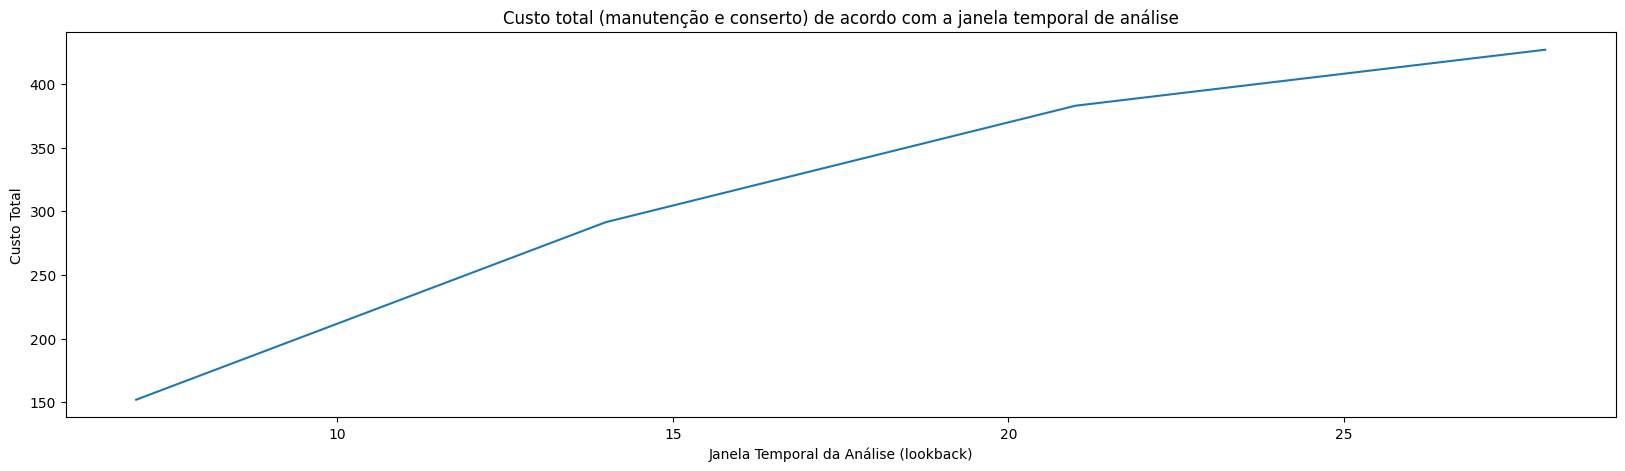

In [137]:
logreg_time = [logreg_dict[i]['time_window'] for i in range(len(logreg_dict))]
logreg_cost = [logreg_dict[i]['total_cost'] for i in range(len(logreg_dict))]

fig = plt.figure(figsize=(20, 5))

sns.lineplot(
    x=logreg_time,
    y=logreg_cost
)

plt.xlabel(
    'Janela Temporal da Análise (lookback)',
    fontsize=10
)
plt.ylabel(
    'Custo Total',
    fontsize=10
)
plt.title(
    'Custo total (manutenção e conserto) de acordo com a janela temporal de análise',
    fontsize=12
)

plt.show()

In [138]:
min_cost = min(logreg_cost)

print('A janela temporal {} foi a que apresentou o menor custo ({:.2f})'.format(logreg_dict[logreg_cost.index(min_cost)]['time_window'], min_cost))

A janela temporal 7 foi a que apresentou o menor custo (152.00)


## 4.3 LGBMClassifier

Para o fluxo do modelo LightGBM Classifier serão testados diferentes janelas temporais, buscando o lookback que traga o menor custo de manutenção e conserto.

In [139]:
time_list = [i*7 for i in range(1, 5)]
selected_model = 'lgbm'

lgbm_history, lgbm_dict = exploring_time_window(dataframe=dataframe, time_space=time_list, selected_model=selected_model)

Pipeline 1/4 | Janela temporal: 7
Ajuste de validação - precision: 0.667 | recall: 0.200 | f1: 0.308


,0-pred,1-pred
0-true,11471,1
1-true,8,2



Ajuste de teste - precision: 0.000 | recall: 0.000 | f1: 0.000


,0-pred,1-pred
0-true,12352,1
1-true,9,0


Custos baseados nas predições de teste:
- Manutenção: 0.50
- Conserto de falha: 9.00
TOTAL: 9.50
Custo de conserto de todas as falhas: 9.0
Distância entre real e predito: 0.5
-------------------------------------------

Pipeline 2/4 | Janela temporal: 14
Ajuste de validação - precision: 0.286 | recall: 0.250 | f1: 0.267


,0-pred,1-pred
0-true,10924,5
1-true,6,2



Ajuste de teste - precision: 0.000 | recall: 0.000 | f1: 0.000


,0-pred,1-pred
0-true,11782,5
1-true,8,0


Custos baseados nas predições de teste:
- Manutenção: 2.50
- Conserto de falha: 8.00
TOTAL: 10.50
Custo de conserto de todas as falhas: 8.0
Distância entre real e predito: 2.5
-------------------------------------------

Pipeline 3/4 | Janela temporal: 21
Ajuste de validação - precision: 0.400 | recall: 0.250 | f1: 0.308


,0-pred,1-pred
0-true,10415,3
1-true,6,2



Ajuste de teste - precision: 0.000 | recall: 0.000 | f1: 0.000


,0-pred,1-pred
0-true,11269,1
1-true,6,0


Custos baseados nas predições de teste:
- Manutenção: 0.50
- Conserto de falha: 6.00
TOTAL: 6.50
Custo de conserto de todas as falhas: 6.0
Distância entre real e predito: 0.5
-------------------------------------------

Pipeline 4/4 | Janela temporal: 28
Ajuste de validação - precision: 0.500 | recall: 0.125 | f1: 0.200


,0-pred,1-pred
0-true,9906,1
1-true,7,1



Ajuste de teste - precision: 0.000 | recall: 0.000 | f1: 0.000


,0-pred,1-pred
0-true,10762,0
1-true,5,0


Custos baseados nas predições de teste:
- Manutenção: 0.00
- Conserto de falha: 5.00
TOTAL: 5.00
Custo de conserto de todas as falhas: 5.0
Distância entre real e predito: 0.0
-------------------------------------------



In [140]:
lgbm_dict

[{'total_cost': 9.5,
  'time_window': 7,
  'best_params': {'colsample_bytree': 0.721651211457473,
   'learning_rate': 0.28453398106079486,
   'max_depth': 6.457618966917579,
   'min_child_weight': 6.893665447887487,
   'min_split_gain': 0.46878383871703594,
   'num_leaves': 40.744675534149245,
   'reg_alpha': 0.2364968682814854,
   'subsample': 0.8818335232639936}},
 {'total_cost': 10.5,
  'time_window': 14,
  'best_params': {'colsample_bytree': 0.8181998216598545,
   'learning_rate': 0.10589215453362975,
   'max_depth': 6.566082595939169,
   'min_child_weight': 8.496523567781033,
   'min_split_gain': 0.31075183980362253,
   'num_leaves': 36.52675632864083,
   'reg_alpha': 0.006447131685293695,
   'subsample': 0.7547873863423988}},
 {'total_cost': 6.5,
  'time_window': 21,
  'best_params': {'colsample_bytree': 0.7620024277408034,
   'learning_rate': 0.24784416478141974,
   'max_depth': 5.107051054095158,
   'min_child_weight': 1.0156801125338242,
   'min_split_gain': 0.0431894908097021

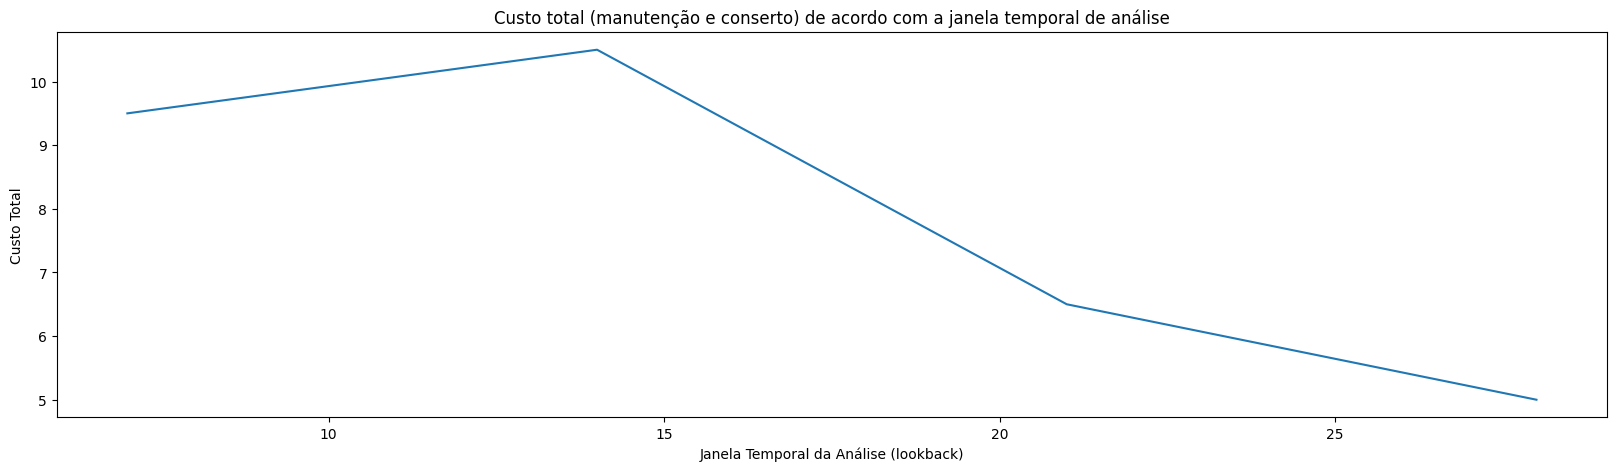

In [141]:
lgbm_time = [lgbm_dict[i]['time_window'] for i in range(len(lgbm_dict))]
lgbm_cost = [lgbm_dict[i]['total_cost'] for i in range(len(lgbm_dict))]

fig = plt.figure(figsize=(20, 5))

sns.lineplot(
    x=lgbm_time,
    y=lgbm_cost
)

plt.xlabel(
    'Janela Temporal da Análise (lookback)',
    fontsize=10
)
plt.ylabel(
    'Custo Total',
    fontsize=10
)
plt.title(
    'Custo total (manutenção e conserto) de acordo com a janela temporal de análise',
    fontsize=12
)

plt.show()

In [142]:
lgbm_min_cost = min(lgbm_cost)

print('A janela temporal {} foi a que apresentou o menor custo ({:.2f})'.format(lgbm_dict[lgbm_cost.index(lgbm_min_cost)]['time_window'], lgbm_min_cost))


A janela temporal 28 foi a que apresentou o menor custo (5.00)


## 4.4 LSTM

Para o fluxo desenvolvido utilizando LSTM, será considearada a janela temporal de sete registros.

In [162]:
df_lstm = dataframe.copy()
lstm_time = 7
selected_model = 'lstm'

lstm_getter = GetData(df_lstm)
X_opt, y_opt, X_val, y_val, X_test, y_test = lstm_getter.parse(lstm_time)
class_weights = compute_class_weights(y_opt)

lstm_optimizer = OptModel(X_opt=X_opt, y_opt=y_opt, X_val=X_val, y_val=y_val, selected_model=selected_model, class_weights=class_weights)
best_params = lstm_optimizer.search()

pred_cols = X_opt.drop(columns=['date', 'device']).columns
lstm_model = FitModel(selected_model=selected_model, best_params=best_params, class_weights=class_weights, pred_cols=pred_cols)
lstm_history = lstm_model.fit(X_opt, y_opt)
y_val_hat, y_test_hat = lstm_model.predict(X_val, X_test)

Trial 5 Complete [00h 08m 51s]
val_prc: 0.0018912587547674775

Best val_prc So Far: 0.009423761628568172
Total elapsed time: 00h 42m 02s
INFO:tensorflow:Oracle triggered exit
Epoch 1/20
91/91 [==============================] - 36s 372ms/step - loss: 1.3852 - prc: 9.6974e-04 - precision: 9.0307e-04 - recall: 0.8916
Epoch 2/20
91/91 [==============================] - 33s 365ms/step - loss: 1.3878 - prc: 8.2373e-04 - precision: 0.0012 - recall: 0.0602
Epoch 3/20
91/91 [==============================] - 33s 368ms/step - loss: 1.3883 - prc: 7.7965e-04 - precision: 7.5893e-04 - recall: 0.4699
Epoch 4/20
91/91 [==============================] - 33s 365ms/step - loss: 1.3828 - prc: 0.0011 - precision: 9.7914e-04 - recall: 0.6627
Epoch 5/20
91/91 [==============================] - 33s 368ms/step - loss: 1.3896 - prc: 9.2431e-04 - precision: 0.0011 - recall: 0.4217
Epoch 6/20
91/91 [==============================] - 33s 367ms/step - loss: 1.3826 - prc: 0.0011 - precision: 9.6349e-04 - recall: 0.

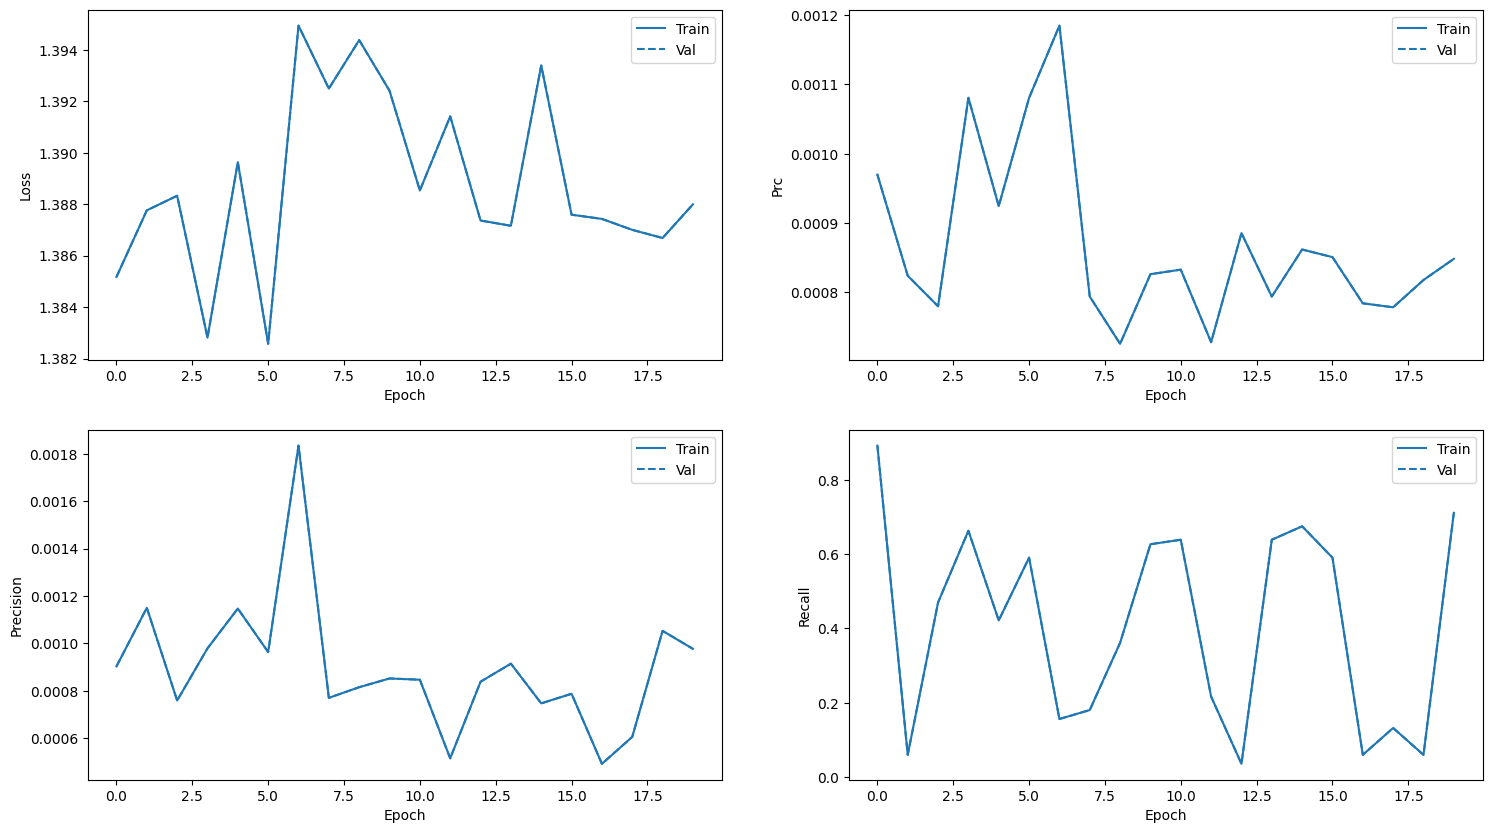

In [163]:
mpl.rcParams['figure.figsize'] = (18, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
metrics = ['loss', 'prc', 'precision', 'recall']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(lstm_history.epoch, lstm_history.history[metric], color=colors[0], label='Train')
    plt.plot(lstm_history.epoch, lstm_history.history[metric],
            color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'auc':
        plt.ylim([0.8,1])

    plt.legend()

In [164]:
model_evaluate = ModelEvaluate(dataframe=dataframe, y_val=y_val, y_val_hat=y_val_hat, y_test=y_test, y_test_hat=y_test_hat)
total_cost = model_evaluate.report()

Ajuste de validação - precision: 0.001 | recall: 1.000 | f1: 0.002


,0-pred,1-pred
0-true,0,11472
1-true,0,10



Ajuste de teste - precision: 0.001 | recall: 1.000 | f1: 0.001


,0-pred,1-pred
0-true,0,12353
1-true,0,9


Custos baseados nas predições de teste:
- Manutenção: 6181.00
- Conserto de falha: 0.00
TOTAL: 6181.00
Custo de conserto de todas as falhas: 9.0
Distância entre real e predito: 6172.0


## 4.5 padding-LSTM

Nos fluxos apresentados anteriormente, as janelas temporais foram utilizadas para desenvolver um lookback em cada registro dos dispositivos da base de dados. Nesse processo, dispositivos com quantidade de registros menor que a janela temporal foram desconsiderados.

A proposta nesse fluxo atual é considerar uma única vez cada dispositivo, utilizando a janela temporal definida para limitar o lookback de parâmetros realizado e fazendo um padding em dispositivos com quantidade de registros menor do que o a janela temporal escolhida.

Como a preparação da base será diferente dos fluxos anteriores, foi optado por trazer o código utilizado no fluxo de forma explícita.

**PREPARAÇÃO DOS DADOS**

In [165]:
# definição do dataframe e do objeto responsável pelo fluxo de transformação
df_lstm = dataframe.copy()

# definição das colunas que serão utilizadas nas etapas de normalização
norm_cols = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']

for col in norm_cols:

    # adição do valor mínimo de cada coluna, removendo zeros, para remoção de valores nulos
    df_lstm[f'norm_{col}'] = df_lstm[col] + df_lstm.drop(df_lstm[df_lstm[col]==0].index, axis=0)[col].min()

    # realização do processo de normalização a partir de aplicação de log
    df_lstm[f'norm_{col}'] = np.log(df_lstm[f'norm_{col}'])

In [166]:
 # criação de dataframe auxiliar com códigos dos dipositivos e atributo que indica falha (grão de dispositivo)
dataframe_split = df_lstm[['device', 'about_to_fail']].groupby(['device']).max().reset_index(drop=False)

# separação inicial do dataframe no grão de dipositivos, estratificando pela proporção do atributo `about_to_fail`.
X_id_train, X_id_test, y_train, y_test = train_test_split(
    dataframe_split['device'],
    dataframe_split['about_to_fail'],
    train_size=0.8,
    stratify=dataframe_split['about_to_fail']
)
    
X_id_opt, X_id_val, y_opt, y_val = train_test_split(
    X_id_train,
    y_train,
    train_size=0.75,
    stratify=y_train
)

In [167]:
# definição das colunas que serão utilizadas nas etapas de predição
pred_cols = df_lstm.drop(columns=['about_to_fail']).columns

# criação das bases de otimização, validação e teste com as colunas de atributos
X_opt = df_lstm[df_lstm['device'].isin(X_id_opt.values)].sort_values(['device', 'date'], ascending=(True, True))[pred_cols]
X_val = df_lstm[df_lstm['device'].isin(X_id_val.values)].sort_values(['device', 'date'], ascending=(True, True))[pred_cols]
X_test = df_lstm[df_lstm['device'].isin(X_id_test.values)].sort_values(['device', 'date'], ascending=(True, True))[pred_cols]

X_opt.shape, X_val.shape, X_test.shape

((76791, 19), (22077, 19), (25460, 19))

In [168]:
# definição das colunas que serão utilizadas nas etapas de escalonamento
scaler_cols = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']

# definição do objeto responsável pelo fluxo de escalonamento
scaler = MinMaxScaler()

for col in scaler_cols:
    X_opt[col] = scaler.fit_transform(X_opt[[col]])
    X_val[col] = scaler.transform(X_val[[col]])
    X_test[col] = scaler.transform(X_test[[col]])

In [169]:
def features_to_seq(device_df: pd.DataFrame, seq_length: int, feat_cols: list):
    '''
    Realiza a parametrização dos atributos dos dispositvos, com base na janela temporal definida.

    Args:
        dataframe: dataframe com as variáveis preditoras.
        seq_length: tamanho da sequência de parâmetros que serão criados (janela temporal | lookback).
        feat_cols: colunas que serão parametrizadas.

    Returns:
        padding_df[feat_cols].values: array com atributos preditores parametrizados.
    '''

    # criação de dataframe com zeros, que auxiliará no processo de padding
    zeros_df = pd.DataFrame(
        np.zeros((seq_length, device_df.shape[1])),
        columns=device_df.columns
    )

    # criação de dataframe com recorte do tamanho da sequência de parâmetros selecionada
    padding_df = pd.concat(
        [zeros_df, device_df],
        ignore_index=True
    ).iloc[-seq_length:, :]

    return padding_df[feat_cols].values

In [170]:
# definição da janela temporal que será levada em conta para modelagem. O tamanho será o mesmo considerado no fluxo anterior (LSMT)
seq_length = 7

# definição dos parâmetros que serão utilizados na modelagem
feat_cols = X_opt.drop(columns=['device', 'date']).columns

# criação do tensor de parâmetros de otimização
features_opt = []
for id in X_opt['device'].unique():
    features_opt.append(features_to_seq(X_opt[X_opt['device']==id], seq_length, feat_cols))
features_opt = np.array(features_opt)

# criação do tensor de parâmetros de validação
features_val = []
for id in X_val['device'].unique():
    features_val.append(features_to_seq(X_val[X_val['device']==id], seq_length, feat_cols))
features_val = np.array(features_val)

# criação do tensor de parâmetros de test
features_test = []
for id in X_test['device'].unique():
    features_test.append(features_to_seq(X_test[X_test['device']==id], seq_length, feat_cols))
features_test = np.array(features_test)

# conferência dos tamanhos dos tensores formados
features_opt.shape, features_val.shape, features_test.shape

((699, 7, 17), (234, 7, 17), (234, 7, 17))

In [171]:
# conferência do tamanho das bases da variável alvo (o tamanho deve ser o mesmo dos tensores formados anteriores, agora ambos em grão de dispositivo)
y_opt.shape, y_val.shape, y_test.shape

((699,), (234,), (234,))

In [172]:
# definição dos pesos das classes que serão preditas
class_weight = compute_class_weights(y_opt)
class_weight

{0: 1.097331240188383, 1: 11.274193548387096}

**CRIAÇÃO DO MODELO**

In [173]:
# otimização bayesiana dos parâmetros da rede neural LSTM utilizada
def build_model(hp):
   bayes_model = Sequential()
   bayes_model.add(LSTM(
      input_shape=(seq_length, features_opt.shape[2]),
      return_sequences=True,
      units=hp.Int('lstm-1', min_value=50, max_value=100, step=50)
   ))
   bayes_model.add(Dropout(0.2))
   bayes_model.add(LSTM(
      return_sequences=True,
      units=hp.Int('lstm-2', min_value=20, max_value=60, step=50)
   ))
   bayes_model.add(Dropout(0.2))
   bayes_model.add(LSTM(
      return_sequences=False,
      units=hp.Int('lstm-3', min_value=10, max_value=100, step=50)
   ))
   bayes_model.add(Dropout(0.2))
   bayes_model.add(Dense(
      units=hp.Int('dense-1', min_value=10, max_value=30, step=5),
      activation='relu'
   ))
   bayes_model.add(Dense(
      units=hp.Int('dense-2', min_value=10, max_value=30, step=5),
      activation='relu'
   ))
   bayes_model.add(Dense(
      units=1,
      activation='sigmoid'
   ))

   bayes_optimizer = hp.Choice('Optimizer', values=['Adam', 'Ftrl'])
   if bayes_optimizer == 'Adam':
         bayes_learning_rating = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
   elif bayes_optimizer == 'Ftrl':
         bayes_learning_rating = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
   
   bayes_model.compile(
      optimizer=bayes_optimizer,
      loss='binary_crossentropy',
      metrics = [
         AUC(name='prc', curve='PR'),
         Precision(name='precision'),
         Recall(name='recall')
      ]
   )

   return bayes_model

bayes_tuner = kt.tuners.BayesianOptimization(
   build_model,
   objective=kt.Objective('val_prc', direction='max'),
   max_trials=5,
   overwrite=True,
   project_name='bayes-optimization',
   seed=42
)

bayes_tuner.search(
   features_opt,
   y_opt,
   epochs=20,
   batch_size=1032,
   validation_data=(features_val, y_val),
   class_weight=class_weight,
   use_multiprocessing=True,
   workers=-1
)

Trial 5 Complete [00h 00m 04s]
val_prc: 0.10373649001121521

Best val_prc So Far: 0.11509735882282257
Total elapsed time: 00h 00m 19s
INFO:tensorflow:Oracle triggered exit


In [174]:
# definição dos melhores parâmetros obtidos na otimização bayesiana
best_params = bayes_tuner.get_best_hyperparameters()[0].values
best_params

{'lstm-1': 100,
 'lstm-2': 20,
 'lstm-3': 10,
 'dense-1': 15,
 'dense-2': 30,
 'Optimizer': 'Adam',
 'learning_rate': 0.001}

In [175]:
# criação do modelo a partir dos melhores parâmetros selecionados
model = Sequential()
model.add(LSTM(
   input_shape=(seq_length, features_opt.shape[2]),
   return_sequences=True,
   units=best_params['lstm-1']
))
model.add(Dropout(0.2))
model.add(LSTM(
   return_sequences=True,
   units=best_params['lstm-2']
))
model.add(Dropout(0.2))
model.add(LSTM(
   return_sequences=False,
   units=best_params['lstm-3']
))
model.add(Dropout(0.2))
model.add(Dense(
   units=best_params['dense-1'],
   activation='relu'
))
model.add(Dense(
   units=best_params['dense-2'],
   activation='relu'
))
model.add(Dense(
   units=1,
   activation='sigmoid'
))

model.compile(
   optimizer=best_params['Optimizer'],
   loss='binary_crossentropy',
   metrics = [
      AUC(name='prc', curve='PR'),
      Precision(name='precision'),
      Recall(name='recall')
   ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 100)            47200     
                                                                 
 dropout_3 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_4 (LSTM)               (None, 7, 20)             9680      
                                                                 
 dropout_4 (Dropout)         (None, 7, 20)             0         
                                                                 
 lstm_5 (LSTM)               (None, 10)                1240      
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 15)               

In [176]:
# ajuste do modelo utilizando a base de dados de otimização
model_history = model.fit(
   features_opt,
   y_opt,
   epochs=30,
   batch_size=1032,
   validation_data=(features_val, y_val),
   class_weight=class_weight,
   use_multiprocessing=True,
   workers=-1
)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 1.3886 - prc: 0.0761 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6808 - val_prc: 0.1107 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
1/1 [==============================] - 0s 52ms/step - loss: 1.3872 - prc: 0.0946 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6811 - val_prc: 0.0884 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
1/1 [==============================] - 0s 48ms/step - loss: 1.3862 - prc: 0.0928 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6797 - val_prc: 0.0936 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
1/1 [==============================] - 0s 51ms/step - loss: 1.3862 - prc: 0.0918 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6806 - val_prc: 0.1015 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
1/1 [==============================] - 0s 47ms/step - loss: 1.3859 - prc: 0.0936 - 

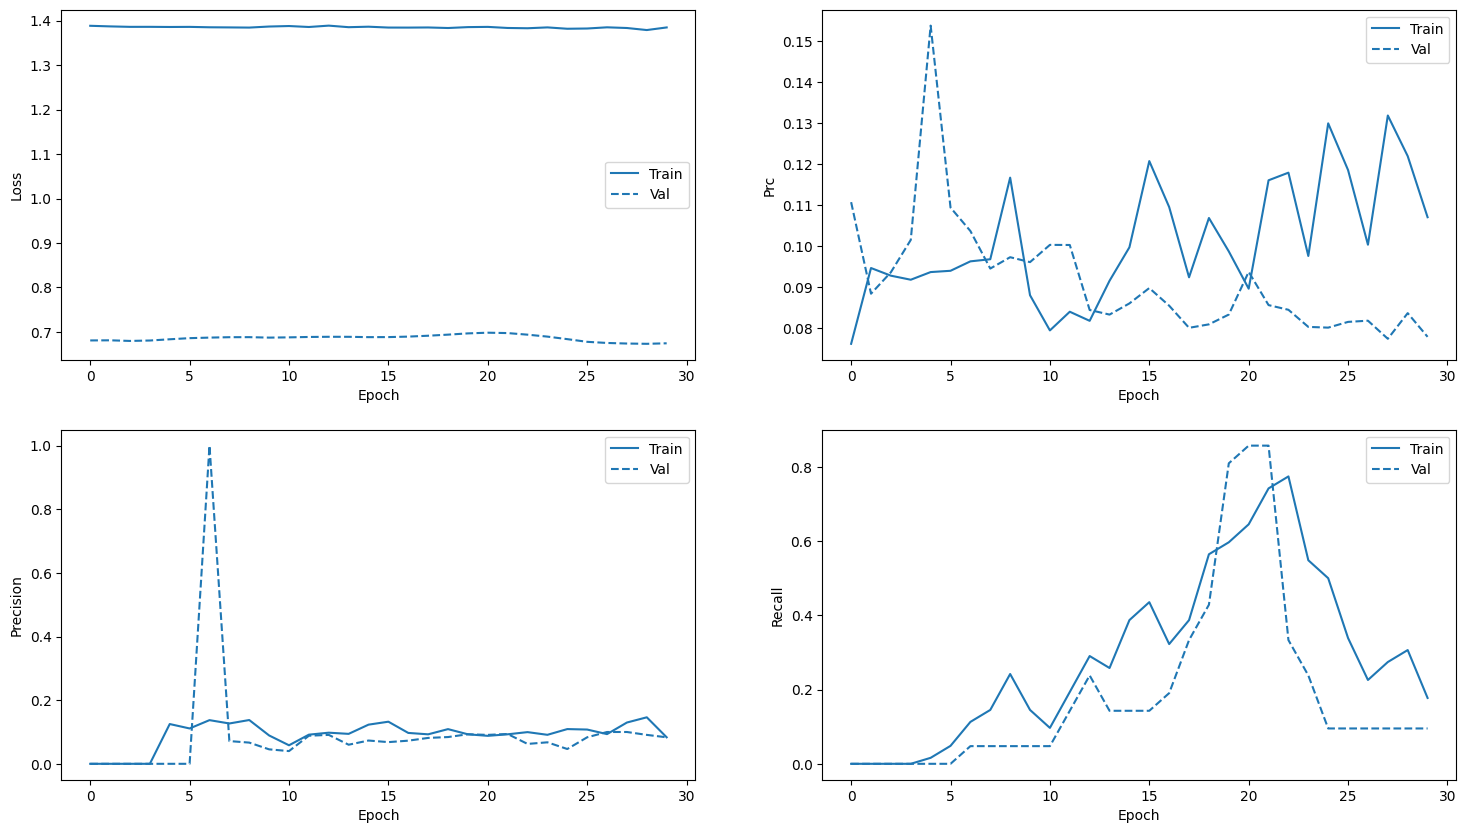

In [177]:
# visualização da evolução das métricas para cada época do ajuste
mpl.rcParams['figure.figsize'] = (18, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
metrics = ['loss', 'prc', 'precision', 'recall']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(model_history.epoch, model_history.history[metric], color=colors[0], label='Train')
    plt.plot(model_history.epoch, model_history.history['val_'+metric],
            color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'auc':
        plt.ylim([0.8,1])

    plt.legend()

In [178]:
# realização da predição da variável alvo a partir dos dados de validação
y_val_hat = model.predict(features_val)
y_val_hat = np.where(y_val_hat >= 0.5, 1, 0)

# realização da predição da variável alvo a partir dos dados de teste
y_test_hat = model.predict(features_test)
y_test_hat = np.where(y_test_hat >= 0.5, 1, 0)

8/8 [==============================] - 0s 2ms/step


In [179]:
lstm_evaluate = ModelEvaluate(dataframe=dataframe, y_val=y_val, y_val_hat=y_val_hat, y_test=y_test, y_test_hat=y_test_hat)
padding_lstm_total_cost = lstm_evaluate.report()

Ajuste de validação - precision: 0.083 | recall: 0.095 | f1: 0.089


,0-pred,1-pred
0-true,191,22
1-true,19,2



Ajuste de teste - precision: 0.080 | recall: 0.095 | f1: 0.087


,0-pred,1-pred
0-true,190,23
1-true,19,2


Custos baseados nas predições de teste:
- Manutenção: 12.50
- Conserto de falha: 19.00
TOTAL: 31.50
Custo de conserto de todas as falhas: 21.0
Distância entre real e predito: 10.5


# 5.0 CONSIDERAÇÕES FINAIS

**SOBRE OS RESULTADOS**

* Apesar de nenhum dos modelos criados conseguiu um resultado melhor de custo total do que a linha base (28.50, com acerto de 30 % dos casos de falha).
* Para o modelo de regressão logística o menor custo foi de 152.00, para uma janela temporal de 7 registros, acertando 67 % dos casos de falha.
* Para o modelo LigthGBM Classifier o menor custo foi de 5.00, para uma janela temporal de 28 registros, acertando 0 % dos casos de falha.
* Para o modelo LSTM, executado com uma janela temporal de 7 registros, o menor custo foi de 6181.00 acertando 100 % dos casos de falha, classificando todos os registros sem falha como falsos positivos.
* Para o modelo padding-LSTM, executado com uma janela temporal de 7 registros, o menor custo foi de 31.50 acertando 9 % dos casos de falha.

**SOBRE OS MODELOS**

* O modelo de regressão logística apresentou desempenho satisfatório de generalização (validação &rarr; teste), porém os ajustes apresentarm um número alto de falsos positivos (gerando altos custos de manutenção)
* O modelo LigthGBM Classifier apresentou indícios de overfitting, ainda assim mostrando baixa performance ao olharmos a quantidade de verdadeiros positivos (gerando altos custos de conserto). Para esse modelo, o ajuste na base de teste não apresentou nenhum acerto de casos de falha.
* O modelo LSTM maximizou o *recall* classificando todos os registros como classe positiva. Apesar do modelo zerar os custos em conserto, ocorreu a explosão dos custos de manutenção.
* O modelo padding-LSTM teve uma performance satisfatória quando olhamos a quantidade de falsos positivos, porém apresentou uma alta proporção de verdadeiros positivos.

**PLANEJAMENTO DE PRÓXIMOS PASSOS**

* Criação de novos parâmetros dentro das janelas temporais de análise ['attributeN_mean', 'attributeN_range', 'attributeN_std'].
* Tentativa de métodos de *data augmentation*
* Avaliação da importância dos parâmetros para o modelo de classificação, na tentativa de diminuir a dimensionalidade.
* Experimentação de outros algoritmos de árvore [CatBoost, XGBoost].
* Experimentação de novos espaçoes de hiperparâmetros para otimização bayesiana.
* Experimentação de outros métodos e ferramentas de otimização [optuna]
* Experimentação de outras estruturas de redes neurais profundas.